## Evaluation of Ensembling Trading Strategies on the S&P 500 Index

In [43]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [44]:
# Download S&P500 Stock Price Data
# 'YYYY-MM-DD'
ticker = 'SPY' #input("enter stock ticker")
start_date = '2018-01-01' #input("enter start date (YYYY-MM-DD)")
end_date = '2023-11-03'
df= yf.download(ticker, start=start_date, end = end_date)
df.index = pd.to_datetime(df.index) #change df index to datetime format
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,267.839996,268.809998,267.399994,268.769989,244.057831,86655700
2018-01-03,268.959991,270.640015,268.959991,270.470001,245.601501,90070400
2018-01-04,271.200012,272.160004,270.540009,271.609985,246.636642,80636400
2018-01-05,272.510010,273.559998,271.950012,273.420013,248.280228,83524000
2018-01-08,273.309998,274.100006,272.980011,273.920013,248.734299,57319200


In [45]:
df.index

DatetimeIndex(['2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05',
               '2018-01-08', '2018-01-09', '2018-01-10', '2018-01-11',
               '2018-01-12', '2018-01-16',
               ...
               '2023-10-20', '2023-10-23', '2023-10-24', '2023-10-25',
               '2023-10-26', '2023-10-27', '2023-10-30', '2023-10-31',
               '2023-11-01', '2023-11-02'],
              dtype='datetime64[ns]', name='Date', length=1470, freq=None)

### 1. Trading Strategy 1: Bollinger Band Strategy
Description:

In [46]:
def generate_signal_BB(df, lookback_window,std_dev,plot=False):
  """Generates a signal based on Bollinger Bands"""
  # Create a copy of the dataframe
  df_signal = df.copy()

  # Use yesterday's adjusted close for today's decision to prevent lookahead bias
  df_signal['Adj Close'] = df_signal['Adj Close'].shift(1)

  # Calculate the rolling mean and standard deviation
  df_signal['SMA'] = df_signal['Adj Close'].rolling(window=lookback_window).mean()
  df_signal['STD'] = df_signal['Adj Close'].rolling(window=lookback_window).std()

  # Drop na
  df_signal = df_signal.dropna()

  # Calculate Bollinger Bands
  df_signal['Upper'] = df_signal['SMA'] + (df_signal['STD'] * std_dev)
  df_signal['Lower'] = df_signal['SMA'] - (df_signal['STD'] * std_dev)

  # Calculate the Bollinger Band trading signal
  # Create a signal column (1 for Buy, -1 for Sell, 0 for Hold)
  df_signal['BB_Signal'] = 0
  df_signal.loc[df_signal['Adj Close'] > df_signal['Upper'], 'BB_Signal'] = -1  # Sell signal
  df_signal.loc[df_signal['Adj Close'] < df_signal['Lower'], 'BB_Signal'] = 1   # Buy signal

  # Define stock position
  stock_position = [0 for i in range(len(df_signal))]

  for i in range(1, len(df_signal)):
    # If there is no position
    if df_signal['BB_Signal'].iloc[i] == 1 and stock_position[i-1] == 0:
      stock_position[i] = 1
    elif df_signal['BB_Signal'].iloc[i] == -1 and stock_position[i-1] == 0:
      stock_position[i] = -1
    # If there is a long position
    elif stock_position[i-1] == 1 and (df_signal['BB_Signal'].iloc[i] == 1 or df_signal['BB_Signal'].iloc[i] == 0):
      stock_position[i] = 1
    elif stock_position[i-1] == 1 and df_signal['BB_Signal'].iloc[i] == -1:
      stock_position[i] = -1
    # If there is a short position
    elif stock_position[i-1] == -1 and (df_signal['BB_Signal'].iloc[i] == -1 or df_signal['BB_Signal'].iloc[i] == 0):
      stock_position[i] = -1
    elif stock_position[i-1] == -1 and df_signal['BB_Signal'].iloc[i] == 1:
      stock_position[i] = 1
    else:
      stock_position[i] = 0

  df_signal['BB_Stock_Position'] = stock_position

  # Calculate BB strategy Daily Returns
  df_signal['BB_Daily_Return'] = df_signal['Adj Close'].pct_change() * df_signal['BB_Stock_Position']
  df_signal['BB_Cumulative_Return'] = ((df_signal['BB_Daily_Return']+1).cumprod()-1)*100

  # Generate average and std of daily returns from past 3 days
  df_signal['BB_Daily_Return_3_Day_Avg'] = df_signal['BB_Daily_Return'].shift(1).rolling(window=3).mean()
  df_signal['BB_Daily_Return_3_Day_Std'] = df_signal['BB_Daily_Return'].shift(1).rolling(window=3).std()

  if plot:
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(20,16))
    # Plot the bollinger bands and adj close lines
    ax1.plot(df_signal[['Adj Close', 'SMA', 'Upper', 'Lower']])
    # Plot the buy signals
    ax1.plot(df_signal[df_signal['BB_Signal'] == 1].index,
            df_signal['Adj Close'][df_signal['BB_Signal'] == 1],
            '^', markersize=10, color='g')
    # Plot the sell signals
    ax1.plot(df_signal[df_signal['BB_Signal'] == -1].index,
            df_signal['Adj Close'][df_signal['BB_Signal'] == -1],
            'v', markersize=10, color='r')
    # Set the title and axes label
    ax1.set_title('Bollinger Band Trading Signals')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price ($)')
    # Set the legend
    ax1.legend(['Adj Close', 'Middle Band','Upper Band / Sell Signal', 'Lower Band / Buy Signal'])

    # Plot the bollinger bands and adj close lines
    ax2.plot(df_signal[['Adj Close', 'Upper', 'Lower']])
    # Plot the long position
    ax2.plot(df_signal[df_signal['BB_Stock_Position'] == 1].index,
            df_signal['Adj Close'][df_signal['BB_Stock_Position'] == 1],
            '^', markersize=10, color='g')
    # Plot the short position
    ax2.plot(df_signal[df_signal['BB_Stock_Position'] == -1].index,
            df_signal['Adj Close'][df_signal['BB_Stock_Position'] == -1],
            'v', markersize=10, color='r')
    # Set the title and axes label
    ax2.set_title('Bollinger Band Stock Position')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Price ($)')
    # Set the legend
    ax2.legend(['Adj Close', 'Upper Band / Sell Signal', 'Lower Band / Buy Signal'])

    # Plot the cumulative strategy returns
    ax3.plot(df_signal['BB_Cumulative_Return'])
    ax3.set_title('Bollinger Band Strategy Returns')
    ax3.set_xlabel('Date')
    ax3.set_ylabel('Cumulative Returns (%)')
    # Show the plot
    plt.show()


  return df_signal

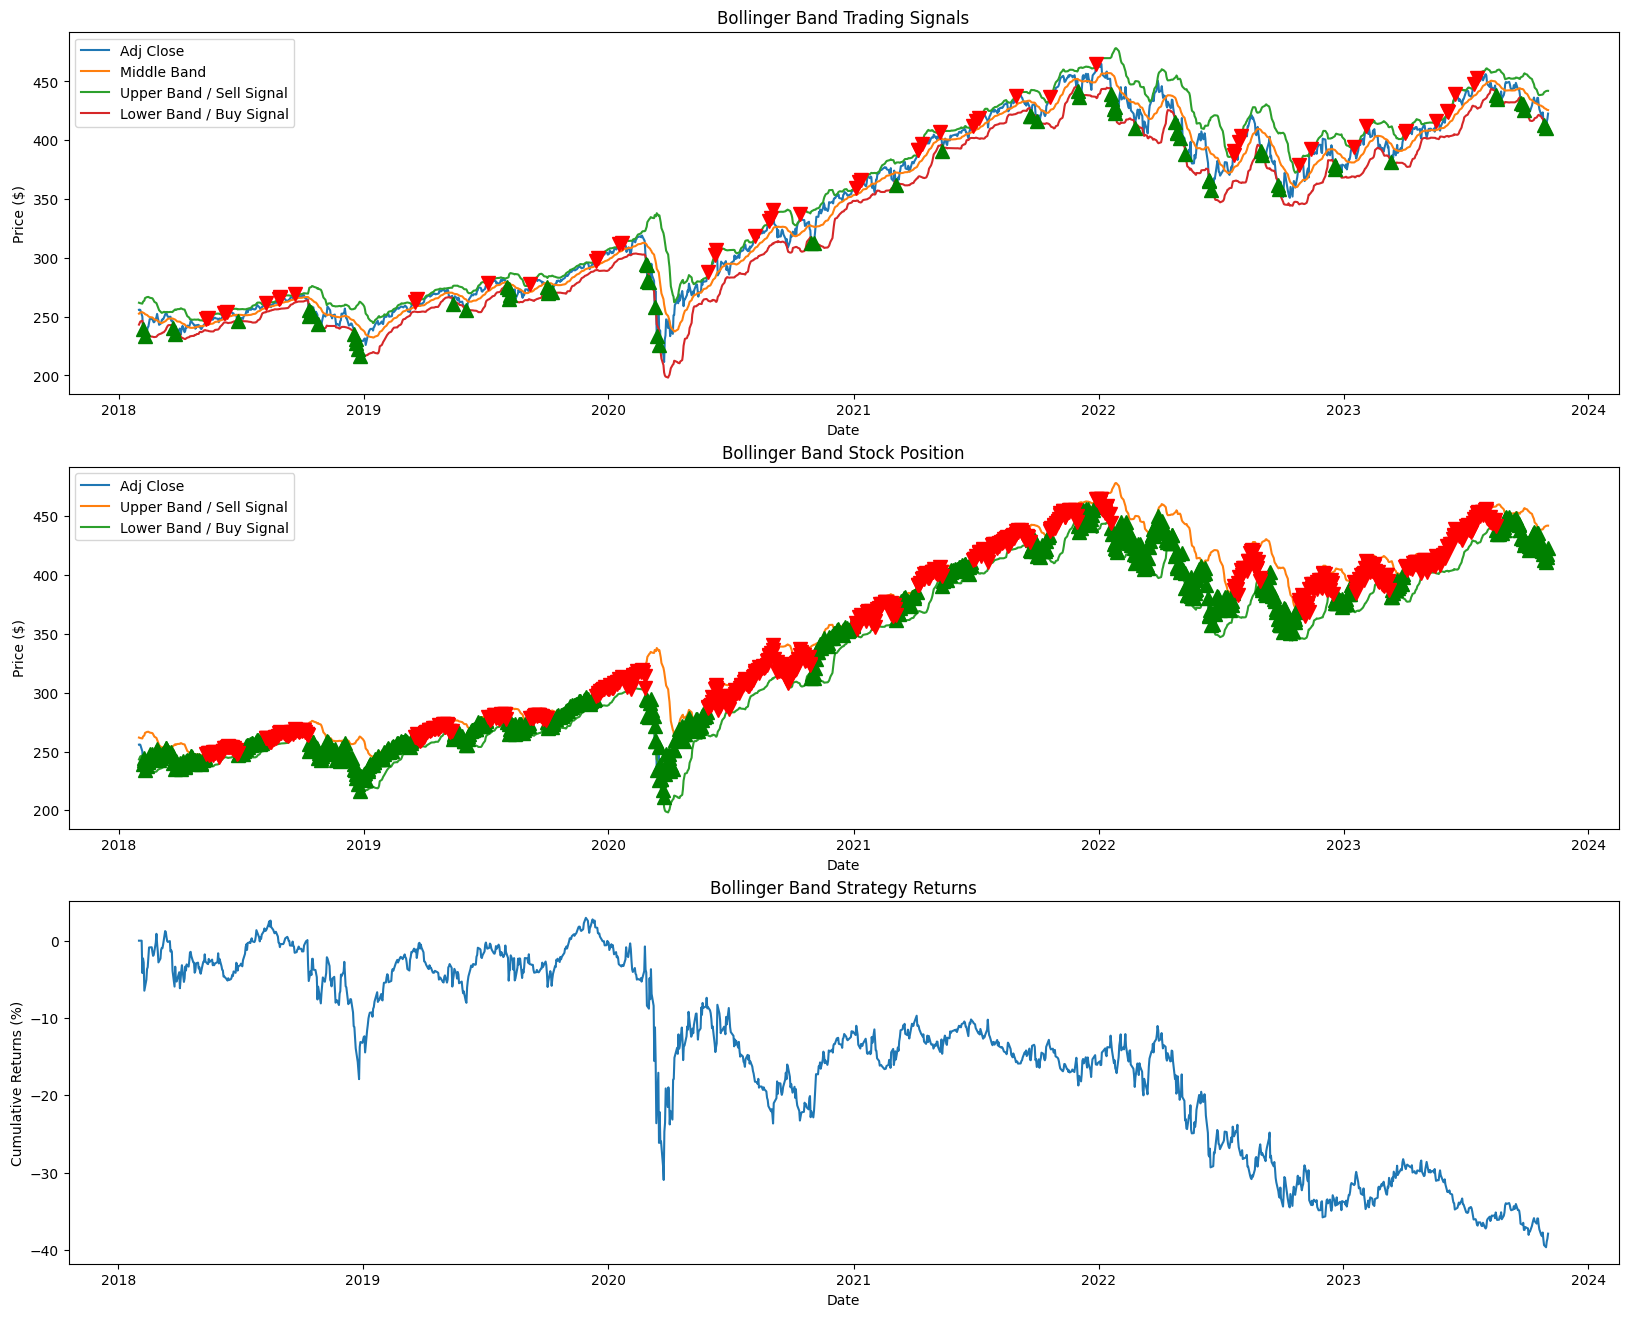

,Open,High,Low,Close,Adj Close,Volume,SMA,STD,Upper,Lower,BB_Signal,BB_Stock_Position,BB_Daily_Return,BB_Cumulative_Return,BB_Daily_Return_3_Day_Avg,BB_Daily_Return_3_Day_Std
Date,,,,,,,,,,,,,,,,
2018-02-06,259.940002,269.700012,258.700012,269.130005,239.662811,355026800,253.396670,4.683808,262.764285,244.029054,1,1,-0.041822,-4.182235,-0.000000,0.000000
2018-02-07,268.500000,272.359985,267.579987,267.670013,244.384674,167376100,253.179189,5.001870,263.182929,243.175448,0,1,0.019702,-2.294423,-0.013941,0.024146
2018-02-08,268.010010,268.170013,257.589996,257.630005,243.058914,246449500,252.867275,5.432648,263.732571,242.001979,0,1,-0.005425,-2.824465,-0.007373,0.031418
2018-02-09,260.799988,263.609985,252.919998,261.500000,233.942078,283565300,252.118586,6.852193,265.822971,238.414201,1,1,-0.037509,-6.469398,-0.009182,0.030934
2018-02-12,263.829987,267.010010,261.660004,265.339996,237.456238,143736000,251.454800,7.596217,266.647235,236.262366,0,1,0.015021,-5.064428,-0.007744,0.028676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-27,414.190002,414.600006,409.209991,410.679993,412.549988,107367700,427.373500,6.653005,440.679510,414.067490,1,1,-0.011975,-39.396101,-0.002849,0.010988
2023-10-30,413.559998,416.679993,412.220001,415.589996,410.679993,86562700,426.533499,7.627985,441.789469,411.277530,1,1,-0.004533,-39.670804,-0.006262,0.012012
2023-10-31,416.179993,418.529999,414.209991,418.200012,415.589996,79665200,425.947499,8.006005,441.959510,409.935489,0,1,0.011956,-38.949521,-0.010287,0.005123


In [47]:
generate_signal_BB(df, 20, 2,True).dropna()

### 2. Trading Strategy 2: Moving Average Crossover Strategy
Description:

In [48]:
# Function to calculate SMA strategy and cumulative returns
def generate_sma_strategy_signal(df,short_term_window=5, long_term_window=25, plot=False):
  """Generates a signal based on SMA strategy"""
  df_signal = df.copy()

  #Use yesterday's adjusted close for today's decision to prevent lookahead bias
  df_signal['Adj Close'] = df_signal['Adj Close'].shift(1)

  # Calculate short-term and long-term SMAs
  df_signal[f'SMA-{short_term_window}'] = df_signal['Adj Close'].rolling(window=short_term_window).mean()
  df_signal[f'SMA-{long_term_window}'] = df_signal['Adj Close'].rolling(window=long_term_window).mean()

  # Drop na
  df_signal = df_signal.dropna()

  # Define buy and sell signals
  df_signal['SMA_Cross_Signal'] = 0  # Initialize with no signal
  df_signal.loc[(df_signal[f'SMA-{short_term_window}'] > df_signal[f'SMA-{long_term_window}'])&(df_signal[f'SMA-{short_term_window}'].shift(1) < df_signal[f'SMA-{long_term_window}'].shift(1)), 'SMA_Cross_Signal'] = 1
  df_signal.loc[(df_signal[f'SMA-{short_term_window}'] < df_signal[f'SMA-{long_term_window}'])&(df_signal[f'SMA-{short_term_window}'].shift(1) > df_signal[f'SMA-{long_term_window}'].shift(1)), 'SMA_Cross_Signal'] = -1



  # Define stock position
  stock_position = [0 for i in range(len(df_signal))]

  for i in range(1, len(df_signal)):
    # If there is no position
    if df_signal['SMA_Cross_Signal'].iloc[i] == 1 and stock_position[i-1] == 0:
      stock_position[i] = 1
    elif df_signal['SMA_Cross_Signal'].iloc[i] == -1 and stock_position[i-1] == 0:
      stock_position[i] = -1
    # If there is a long position
    elif stock_position[i-1] == 1 and (df_signal['SMA_Cross_Signal'].iloc[i] == 1 or df_signal['SMA_Cross_Signal'].iloc[i] == 0):
      stock_position[i] = 1
    elif stock_position[i-1] == 1 and df_signal['SMA_Cross_Signal'].iloc[i] == -1:
      stock_position[i] = -1
    # If there is a short position
    elif stock_position[i-1] == -1 and (df_signal['SMA_Cross_Signal'].iloc[i] == -1 or df_signal['SMA_Cross_Signal'].iloc[i] == 0):
      stock_position[i] = -1
    elif stock_position[i-1] == -1 and df_signal['SMA_Cross_Signal'].iloc[i] == 1:
      stock_position[i] = 1
    else:
      stock_position[i] = 0

  df_signal['SMA_Stock_Position'] = stock_position

  # Calculate strategy daily returns
  df_signal['SMA_Cross_Daily_Return'] = df_signal['Adj Close'].pct_change() *  df_signal['SMA_Stock_Position']
  df_signal['SMA_Cumulative_Return'] = ((df_signal['SMA_Cross_Daily_Return'] + 1).cumprod() - 1)*100

  # Generate average and std of daily returns from past 3 days
  df_signal['SMA_Cross_Daily_Return_3_Day_Avg'] = df_signal['SMA_Cross_Daily_Return'].shift(1).rolling(window=3).mean()
  df_signal['SMA_Cross_Daily_Return_3_Day_Std'] = df_signal['SMA_Cross_Daily_Return'].shift(1).rolling(window=3).std()

  if plot:
    # Plot signals
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(20,16))
    # Plot the SMAs and adj close lines
    ax1.plot(df_signal[['Adj Close', f'SMA-{short_term_window}', f'SMA-{long_term_window}']])
    # Plot the buy signals
    ax1.plot(df_signal[df_signal['SMA_Cross_Signal'] == 1].index,
            df_signal['Adj Close'][df_signal['SMA_Cross_Signal'] == 1],
            '^', markersize=10, color='g')
    # Plot the sell signals
    ax1.plot(df_signal[df_signal['SMA_Cross_Signal'] == -1].index,
            df_signal['Adj Close'][df_signal['SMA_Cross_Signal'] == -1],
            'v', markersize=10, color='r')
    # Set the title and axes label
    ax1.set_title('SMA Trading Signals')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price ($)')
    # Set the legend
    ax1.legend(['Adj Close', f'SMA-{short_term_window}', f'SMA-{long_term_window}', 'Buy Signal', 'Sell Signal'])

    # Plot the SMAs and adj close lines
    ax2.plot(df_signal[['Adj Close', f'SMA-{short_term_window}', f'SMA-{long_term_window}']])
    # Plot the long position
    ax2.plot(df_signal[df_signal['SMA_Stock_Position'] == 1].index,
            df_signal['Adj Close'][df_signal['SMA_Stock_Position'] == 1],
            '^', markersize=10, color='g')
    # Plot the short position
    ax2.plot(df_signal[df_signal['SMA_Stock_Position'] == -1].index,
            df_signal['Adj Close'][df_signal['SMA_Stock_Position'] == -1],
            'v', markersize=10, color='r')
    # Set the title and axes label
    ax2.set_title('SMA Stock position')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Price ($)')
    # Set the legend
    ax2.legend(['Adj Close', f'SMA-{short_term_window}', f'SMA-{long_term_window}', 'Buy Signal', 'Sell Signal'])

    # Plot the cumulative strategy returns
    ax3.plot(df_signal['SMA_Cumulative_Return'])
    ax3.set_title('SMA Strategy Returns')
    ax3.set_xlabel('Date')
    ax3.set_ylabel('Cumulative Returns (%)')
    plt.show()

  return df_signal

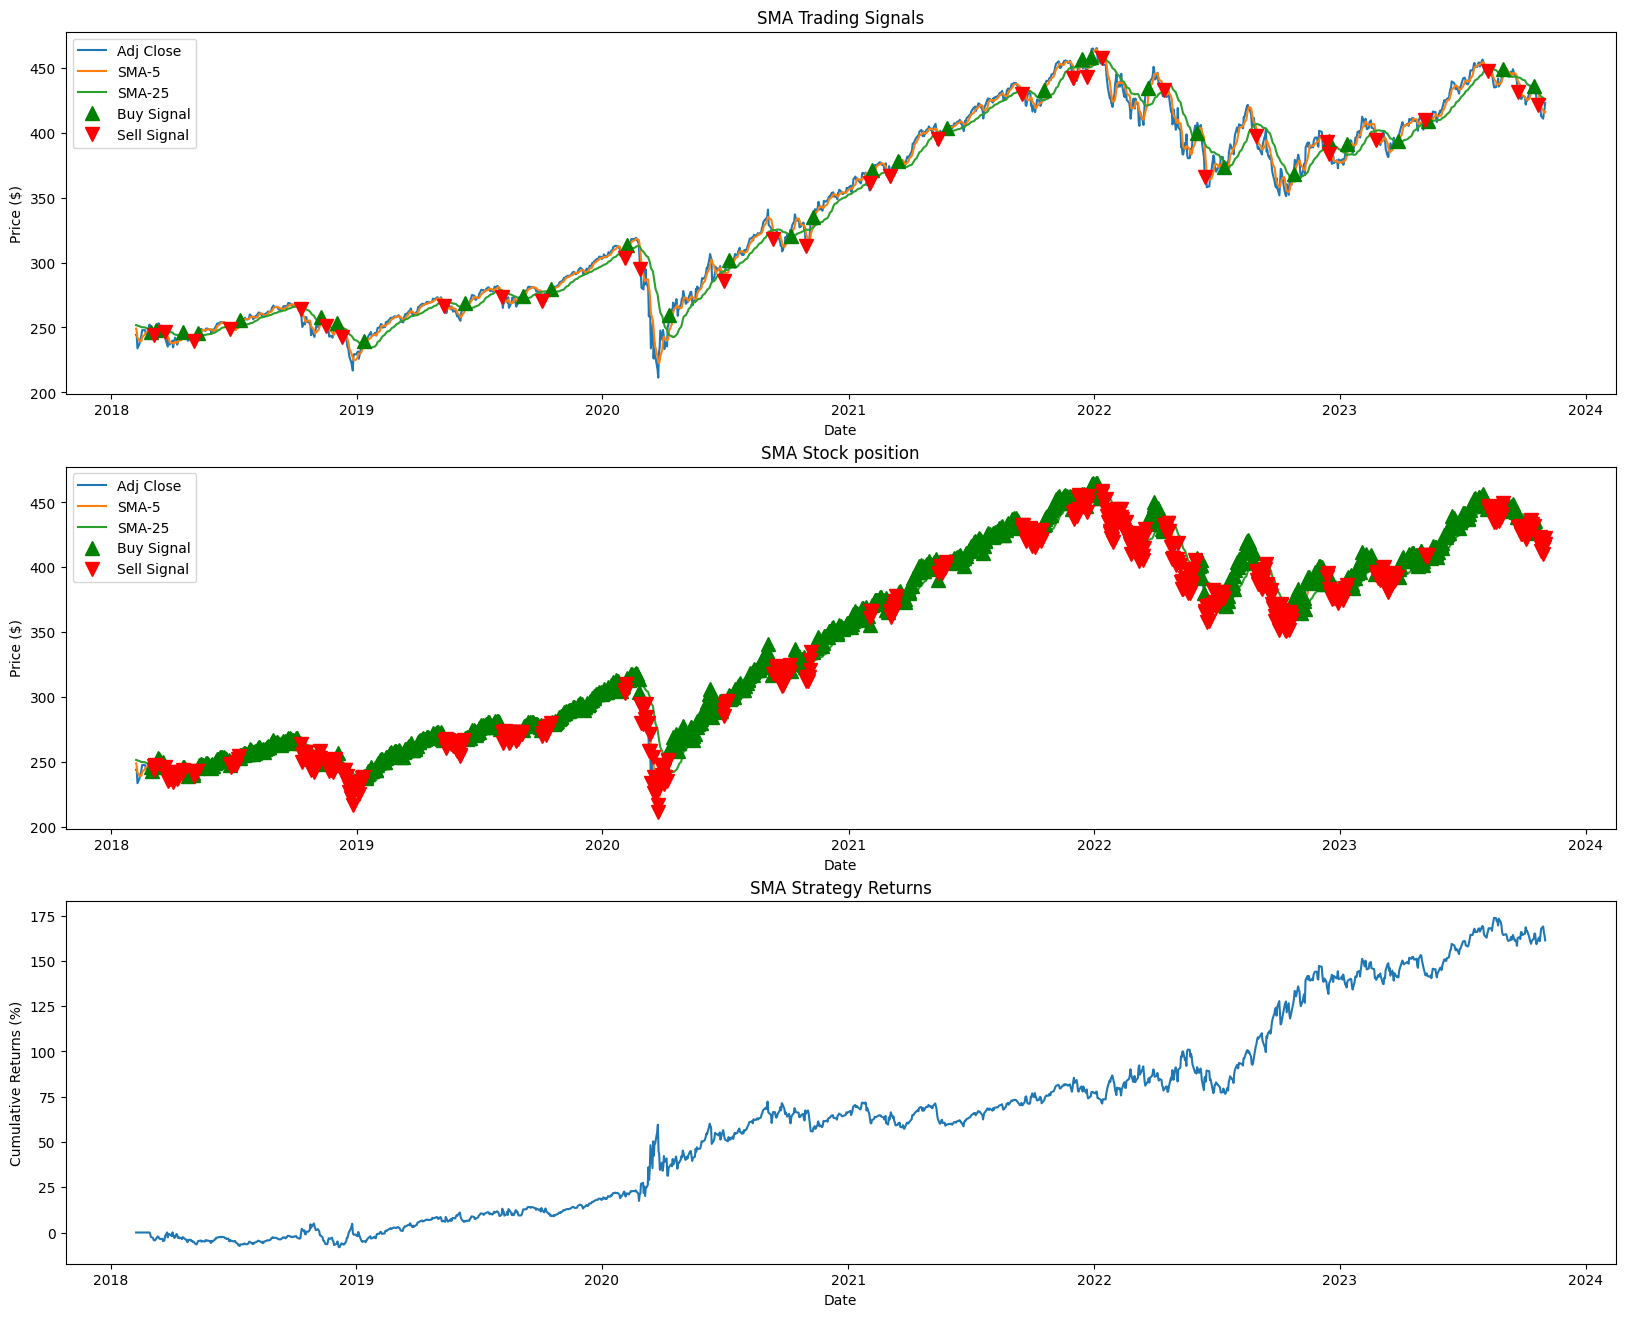

,Open,High,Low,Close,Adj Close,Volume,SMA-5,SMA-25,SMA_Cross_Signal,SMA_Stock_Position,SMA_Cross_Daily_Return,SMA_Cumulative_Return,SMA_Cross_Daily_Return_3_Day_Avg,SMA_Cross_Daily_Return_3_Day_Std
Date,,,,,,,,,,,,,,
2018-02-13,263.970001,266.619995,263.309998,266.000000,240.943115,81223600,239.957004,250.708737,0,0,0.000000,0.000000,0.000000,0.000000
2018-02-14,264.309998,270.000000,264.299988,269.589996,241.542496,120735700,239.388568,250.421064,0,0,0.000000,0.000000,0.000000,0.000000
2018-02-15,271.570007,273.040009,268.769989,273.029999,244.802429,111200300,239.737271,250.241274,0,0,0.000000,0.000000,0.000000,0.000000
2018-02-16,272.320007,275.320007,272.269989,273.109985,247.926102,160420100,242.534076,250.201684,0,0,0.000000,0.000000,0.000000,0.000000
2018-02-20,272.029999,273.670013,270.500000,271.399994,247.998688,86369700,244.642566,250.092354,0,0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-27,414.190002,414.600006,409.209991,410.679993,412.549988,107367700,419.075995,427.622800,0,-1,0.011975,167.787597,0.002849,0.010988
2023-10-30,413.559998,416.679993,412.220001,415.589996,410.679993,86562700,416.973993,426.833199,0,-1,0.004533,169.001417,0.006262,0.012012
2023-10-31,416.179993,418.529999,414.209991,418.200012,415.589996,79665200,415.999994,426.167599,0,-1,-0.011956,165.785292,0.010287,0.005123


In [49]:
generate_sma_strategy_signal(df,plot=True).dropna()

### 3. Trading Strategy 3: Exponential Moving Average Crossover Strategy
Description:

In [50]:
def generate_ema_strategy_signal(df,short_term_window=5, long_term_window=25, plot=False):
  df_signal = df.copy()

  # Use yesterday's adjusted close for today's decision to prevent lookahead bias
  df_signal['Adj Close'] = df_signal['Adj Close'].shift(1)

  # Calculate alpha (smoothing factor) based on the window
  alpha_short = 2 / (short_term_window + 1)
  alpha_long = 2 / (long_term_window + 1)

  # Calculate short-term and long-term EMAs
  df_signal[f'EMA-{alpha_short:.3f}'] = df_signal['Adj Close'].ewm(alpha=alpha_short).mean()
  df_signal[f'EMA-{alpha_long:.3f}'] = df_signal['Adj Close'].ewm(alpha=alpha_long).mean()

  # Drop na
  df_signal = df_signal.dropna()

  # Define buy and sell signals
  df_signal['EMA_Cross_Signal'] = 0  # Initialize with no signal
  df_signal.loc[(df_signal[f'EMA-{alpha_short:.3f}'] > df_signal[f'EMA-{alpha_long:.3f}']) & (df_signal[f'EMA-{alpha_short:.3f}'].shift(1) < df_signal[f'EMA-{alpha_long:.3f}'].shift(1)), 'EMA_Cross_Signal'] = 1  # Buy signal

  df_signal.loc[(df_signal[f'EMA-{alpha_short:.3f}'] < df_signal[f'EMA-{alpha_long:.3f}']) & (df_signal[f'EMA-{alpha_short:.3f}'].shift(1) > df_signal[f'EMA-{alpha_long:.3f}'].shift(1)) , 'EMA_Cross_Signal'] = -1  # Sell signal

  # Define stock position
  stock_position = [0 for i in range(len(df_signal))]

  for i in range(1, len(df_signal)):
    # If there is no position
    if df_signal['EMA_Cross_Signal'].iloc[i] == 1 and stock_position[i-1] == 0:
      stock_position[i] = 1
    elif df_signal['EMA_Cross_Signal'].iloc[i] == -1 and stock_position[i-1] == 0:
      stock_position[i] = -1
    # If there is a long position
    elif stock_position[i-1] == 1 and (df_signal['EMA_Cross_Signal'].iloc[i] == 1 or df_signal['EMA_Cross_Signal'].iloc[i] == 0):
      stock_position[i] = 1
    elif stock_position[i-1] == 1 and df_signal['EMA_Cross_Signal'].iloc[i] == -1:
      stock_position[i] = -1
    # If there is a short position
    elif stock_position[i-1] == -1 and (df_signal['EMA_Cross_Signal'].iloc[i] == -1 or df_signal['EMA_Cross_Signal'].iloc[i] == 0):
      stock_position[i] = -1
    elif stock_position[i-1] == -1 and df_signal['EMA_Cross_Signal'].iloc[i] == 1:
      stock_position[i] = 1
    else:
      stock_position[i] = 0

  df_signal['EMA_Stock_Position'] = stock_position

  # Calculate cumulative returns for the EMA strategy
  df_signal['EMA_Cross_Daily_Return'] = df_signal['Adj Close'].pct_change() *  df_signal['EMA_Stock_Position']
  df_signal['EMA_Cumulative_Return'] = ((1 + df_signal['EMA_Cross_Daily_Return']).cumprod() - 1)*100

  # Generate average and std of daily returns from past 3 days
  df_signal['EMA_Cross_Daily_Return_3_Day_Avg'] = df_signal['EMA_Cross_Daily_Return'].shift(1).rolling(window=3).mean()
  df_signal['EMA_Cross_Daily_Return_3_Day_Std'] = df_signal['EMA_Cross_Daily_Return'].shift(1).rolling(window=3).std()

  if plot:
    # Plot signals
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(20,16))
    # Plot the SMAs and adj close lines
    ax1.plot(df_signal[['Adj Close', f'EMA-{alpha_short:.3f}', f'EMA-{alpha_long:.3f}']])
    # Plot the buy signals
    ax1.plot(df_signal[df_signal['EMA_Cross_Signal'] == 1].index,
            df_signal['Adj Close'][df_signal['EMA_Cross_Signal'] == 1],
            '^', markersize=10, color='g')
    # Plot the sell signals
    ax1.plot(df_signal[df_signal['EMA_Cross_Signal'] == -1].index,
            df_signal['Adj Close'][df_signal['EMA_Cross_Signal'] == -1],
            'v', markersize=10, color='r')
    # Set the title and axes label
    ax1.set_title('EMA Trading Signals')
    # ax1.set_xlabel('Date')
    ax1.set_ylabel('Price ($)')
    # Set the legend
    ax1.legend(['Adj Close', f'EMA-{alpha_short:.3f}', f'EMA-{alpha_long:.3f}', 'Buy Signal', 'Sell Signal'])

    # Plot the SMAs and adj close lines
    ax2.plot(df_signal[['Adj Close', f'EMA-{alpha_short:.3f}', f'EMA-{alpha_long:.3f}']])
    # Plot the long position
    ax2.plot(df_signal[df_signal['EMA_Stock_Position'] == 1].index,
            df_signal['Adj Close'][df_signal['EMA_Stock_Position'] == 1],
            '^', markersize=10, color='g')
    # Plot the short position
    ax2.plot(df_signal[df_signal['EMA_Stock_Position'] == -1].index,
            df_signal['Adj Close'][df_signal['EMA_Stock_Position'] == -1],
            'v', markersize=10, color='r')
    # Set the title and axes label
    ax2.set_title('EMA Stock position')
    # ax2.set_xlabel('Date')
    ax2.set_ylabel('Price ($)')
    # Set the legend
    ax2.legend(['Adj Close', f'EMA-{alpha_short:.3f}', f'EMA-{alpha_long:.3f}', 'Buy Signal', 'Sell Signal'])

    # Plot the cumulative strategy returns
    ax3.plot(df_signal['EMA_Cumulative_Return'])
    ax3.set_title('EMA Strategy Returns')
    ax3.set_xlabel('Date')
    ax3.set_ylabel('Cumulative Returns (%)')
    plt.show()

  return df_signal

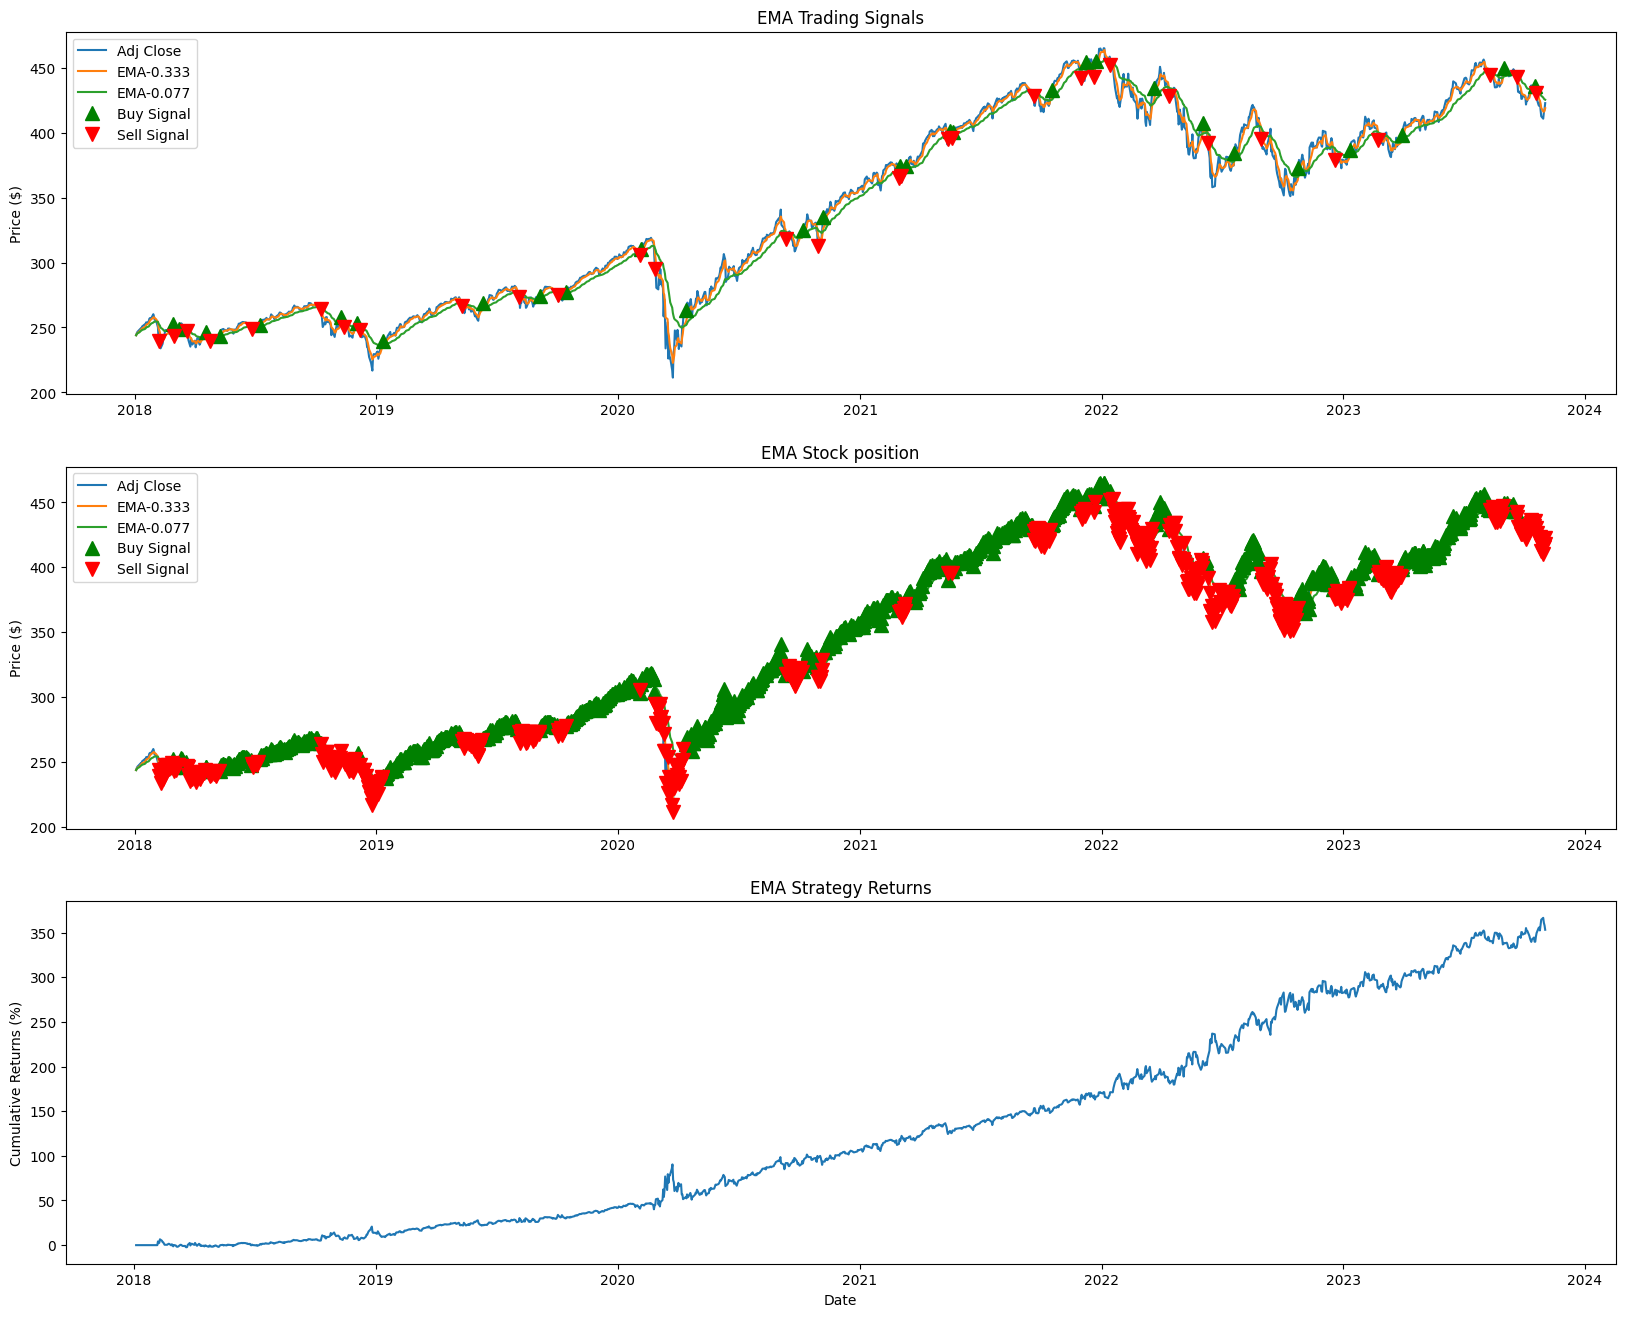

,Open,High,Low,Close,Adj Close,Volume,EMA-0.333,EMA-0.077,EMA_Cross_Signal,EMA_Stock_Position,EMA_Cross_Daily_Return,EMA_Cumulative_Return,EMA_Cross_Daily_Return_3_Day_Avg,EMA_Cross_Daily_Return_3_Day_Std
Date,,,,,,,,,,,,,,
2018-01-09,274.399994,275.250000,274.079987,274.540009,248.734299,57254000,247.549246,246.853160,0,0,0.000000,0.000000,0.000000,0.000000
2018-01-10,273.679993,274.420013,272.920013,274.119995,249.297180,69574300,248.187965,247.346117,0,0,0.000000,0.000000,0.000000,0.000000
2018-01-11,274.750000,276.119995,274.559998,276.119995,248.915863,62361500,248.445681,247.627610,0,0,-0.000000,0.000000,0.000000,0.000000
2018-01-12,276.420013,278.109985,276.079987,277.920013,250.731949,90816100,249.238713,248.132583,0,0,0.000000,0.000000,-0.000000,0.000000
2018-01-16,279.350006,280.089996,276.179993,276.970001,252.366470,106555100,250.309143,248.766906,0,0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-27,414.190002,414.600006,409.209991,410.679993,412.549988,107367700,419.058763,428.340807,0,-1,0.011975,364.396131,0.002849,0.010988
2023-10-30,413.559998,416.679993,412.220001,415.589996,410.679993,86562700,416.265840,426.982282,0,-1,0.004533,366.501133,0.006262,0.012012
2023-10-31,416.179993,418.529999,414.209991,418.200012,415.589996,79665200,416.040559,426.105953,0,-1,-0.011956,360.923744,0.010287,0.005123


In [51]:
generate_ema_strategy_signal(df,plot=True).dropna()

### 4. Trading Strategy 4: Relative Strength Index Strategy
Description:

In [52]:
def generate_signal_RSI(df, window=14, overbought=70, oversold=30, plot=False):
  df_signal = df.copy()

  # Use yesterday's adjusted close for today's decision to prevent lookahead bias
  df_signal['Adj Close'] = df_signal['Adj Close'].shift(1)

  # Overbought and oversold levels
  df_signal['Overbought'] = overbought
  df_signal['Oversold']= oversold

  # Calculate daily price changes
  df_signal['Price_Change'] = df_signal['Adj Close'].diff(1)

  # Calculate daily gains and losses
  df_signal['Gain'] = df_signal['Price_Change'].apply(lambda x: x if x > 0 else 0)
  df_signal['Loss'] = df_signal['Price_Change'].apply(lambda x: abs(x) if x < 0 else 0)

  # Calculate average gains and losses over the specified window
  df_signal['Avg_Gain'] = df_signal['Gain'].rolling(window=window).mean()
  df_signal['Avg_Loss'] = df_signal['Loss'].rolling(window=window).mean()

  # Drop na
  df_signal = df_signal.dropna()

  # Calculate relative strength (RS) and RSI
  df_signal['RS'] = df_signal['Avg_Gain'] / df_signal['Avg_Loss']
  df_signal['RSI'] = 100 - (100 / (1 + df_signal['RS']))

  # Define buy and sell signals based on RSI thresholds
  df_signal['RSI_Signal'] = 0  # Initialize with no signal
  df_signal.loc[df_signal['RSI'] > overbought, 'RSI_Signal'] = -1  # Overbought (sell) signal
  df_signal.loc[df_signal['RSI'] < oversold, 'RSI_Signal'] = 1  # Oversold (buy) signal

  # Define stock position
  stock_position = [0 for i in range(len(df_signal))]

  for i in range(1, len(df_signal)):
    # If there is no position
    if df_signal['RSI_Signal'].iloc[i] == 1 and stock_position[i-1] == 0:
      stock_position[i] = 1
    elif df_signal['RSI_Signal'].iloc[i] == -1 and stock_position[i-1] == 0:
      stock_position[i] = -1
    # If there is a long position
    elif stock_position[i-1] == 1 and (df_signal['RSI_Signal'].iloc[i] == 1 or df_signal['RSI_Signal'].iloc[i] == 0):
      stock_position[i] = 1
    elif stock_position[i-1] == 1 and df_signal['RSI_Signal'].iloc[i] == -1:
      stock_position[i] = -1
    # If there is a short position
    elif stock_position[i-1] == -1 and (df_signal['RSI_Signal'].iloc[i] == -1 or df_signal['RSI_Signal'].iloc[i] == 0):
      stock_position[i] = -1
    elif stock_position[i-1] == -1 and df_signal['RSI_Signal'].iloc[i] == 1:
      stock_position[i] = 1
    else:
      stock_position[i] = 0

  df_signal['RSI_Stock_Position'] = stock_position

  # Calculate cumulative returns for the RSI strategy
  df_signal['RSI_Daily_Return'] = df_signal['Adj Close'].pct_change() * df_signal['RSI_Stock_Position']
  df_signal['RSI_Cumulative_Return'] = ((df_signal['RSI_Daily_Return']+1).cumprod()-1)*100

  # Generate average and std of daily returns from past 3 days
  df_signal['RSI_Daily_Return_3_Day_Avg'] = df_signal['RSI_Daily_Return'].shift(1).rolling(window=3).mean()
  df_signal['RSI_Daily_Return_3_Day_Std'] = df_signal['RSI_Daily_Return'].shift(1).rolling(window=3).std()

  if plot:
    # Plot signals
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(20,16))
    # Plot the signals and adjusted close prices
    ax1.plot(df_signal[['Adj Close']])
    # Plot the buy signals
    ax1.plot(df_signal[df_signal['RSI_Signal'] == 1].index,
            df_signal['Adj Close'][df_signal['RSI_Signal'] == 1],
            '^', markersize=10, color='g')
    # Plot the sell signals
    ax1.plot(df_signal[df_signal['RSI_Signal'] == -1].index,
            df_signal['Adj Close'][df_signal['RSI_Signal'] == -1],
            'v', markersize=10, color='r')
    # Set the title and axes label
    ax1.set_title('RSI Trading Signals')
    ax1.set_ylabel('Price ($)')
    # Set the legend
    ax1.legend(['Adj Close', 'Buy Signal', 'Sell Signal'])

    # Plot the RSI and oversold/overbought lines and price
    ax2.plot(df_signal[['RSI', 'Overbought', 'Oversold']])
    # Set the title and axes label
    ax2.set_title('RSI')
    ax2.set_ylabel('RSI')
    # Set the legend
    ax2.legend(['RSI', 'Overbought', 'Oversold'])

    # Plot the RSI and oversold/overbought lines and price
    ax3.plot(df_signal[['RSI', 'Adj Close']])
    # Plot the long position
    ax3.plot(df_signal[df_signal['RSI_Stock_Position'] == 1].index,
            df_signal['Adj Close'][df_signal['RSI_Stock_Position'] == 1],
            '^', markersize=10, color='g')
    # Plot the short position
    ax3.plot(df_signal[df_signal['RSI_Stock_Position'] == -1].index,
            df_signal['Adj Close'][df_signal['RSI_Stock_Position'] == -1],
            'v', markersize=10, color='r')
    # Set the title and axes label
    ax3.set_title('RSI Stock Position')
    ax3.set_ylabel('Price ($)')
    # Set the legend
    ax3.legend(['RSI', 'Adj Close', 'Buy Signal', 'Sell Signal'])

    # Plot the cumulative strategy returns
    ax4.plot(df_signal['RSI_Cumulative_Return'])
    ax4.set_title('RSI Strategy Returns')
    ax4.set_ylabel('Cumulative Returns (%)')
    plt.show()
  return df_signal

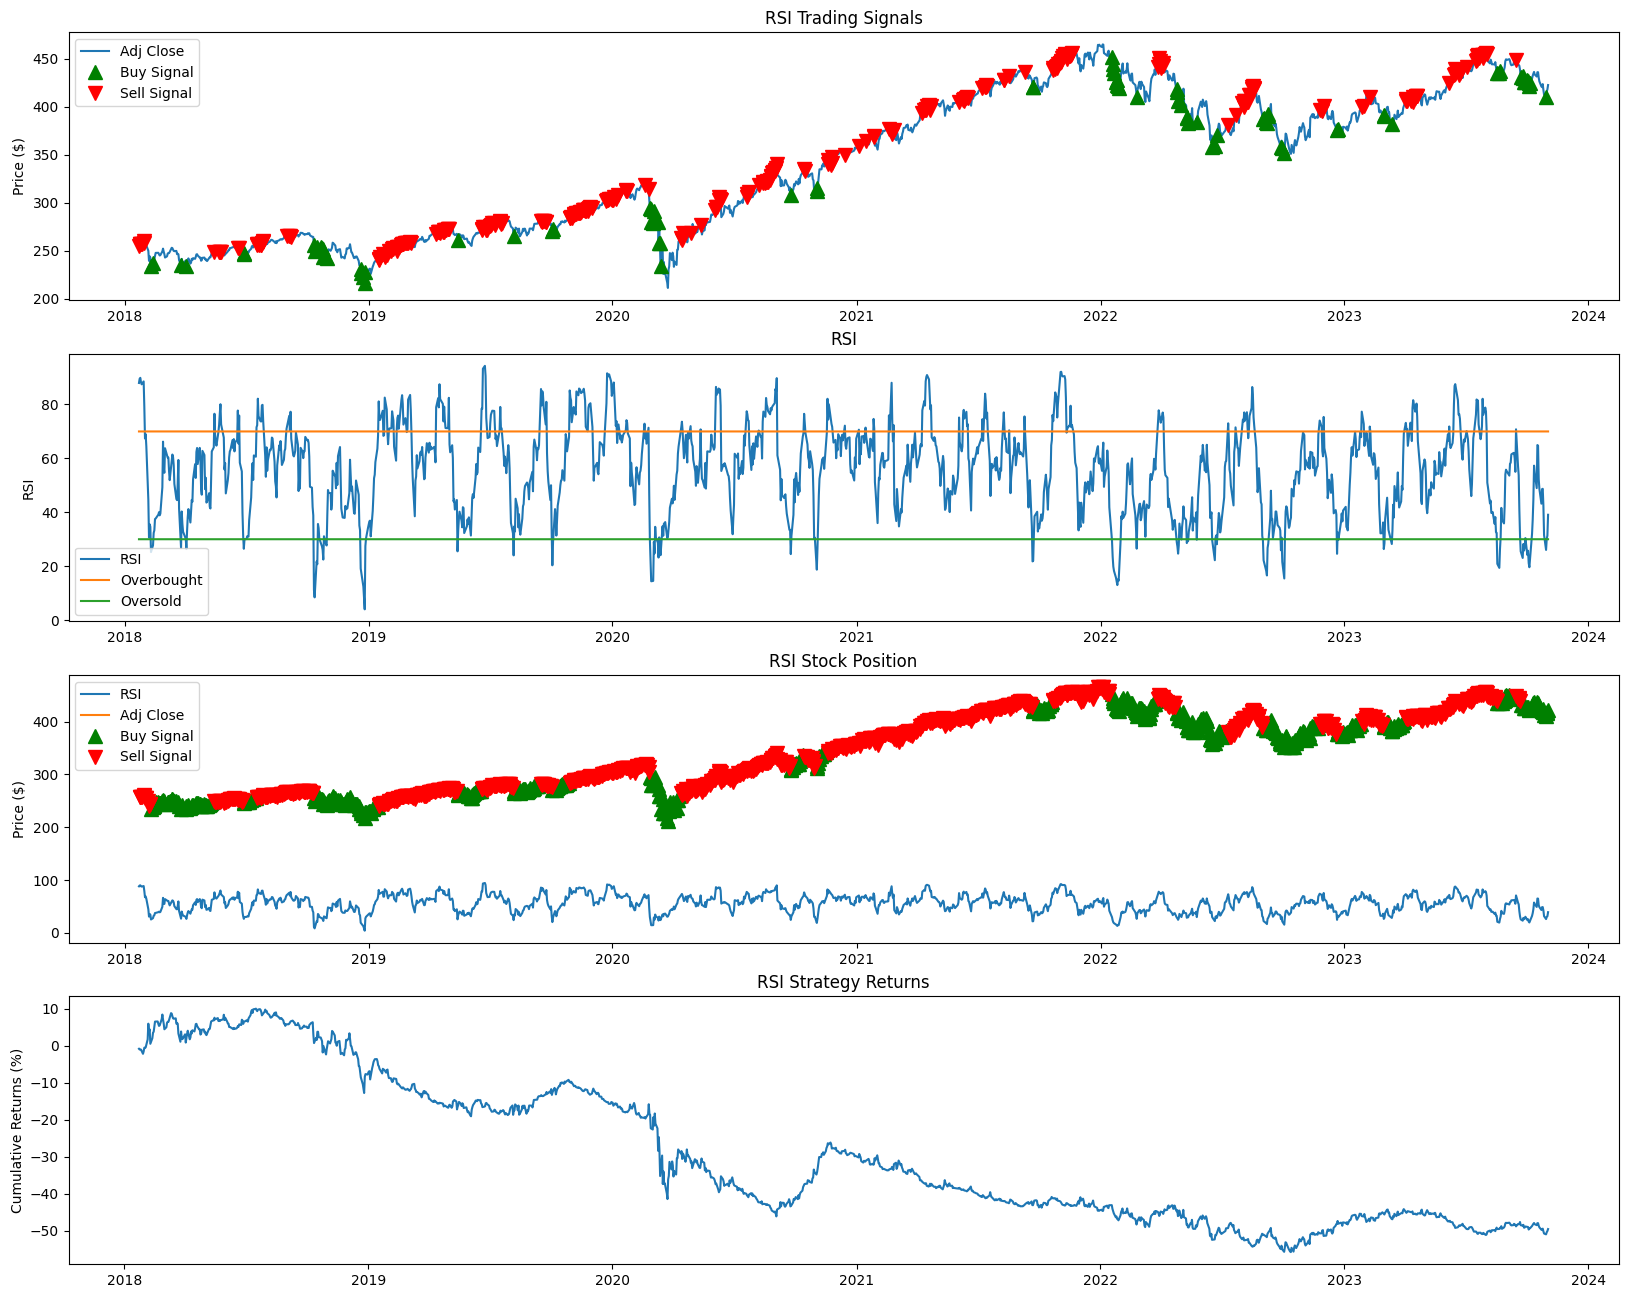

,Open,High,Low,Close,Adj Close,Volume,Overbought,Oversold,Price_Change,Gain,...,Avg_Gain,Avg_Loss,RS,RSI,RSI_Signal,RSI_Stock_Position,RSI_Daily_Return,RSI_Cumulative_Return,RSI_Daily_Return_3_Day_Avg,RSI_Daily_Return_3_Day_Std
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-26,284.250000,286.630005,283.959991,286.579987,257.251740,107743100,70,30,0.108917,0.108917,...,0.884698,0.126477,6.994942,87.492091,-1,-1,-0.000424,-1.027128,-0.003288,0.004378
2018-01-29,285.929993,286.429993,284.500000,284.679993,260.230225,90118300,70,30,2.978485,2.978485,...,0.980048,0.126477,7.748834,88.569906,-1,-1,-0.011578,-2.173045,-0.000719,0.001281
2018-01-30,282.600006,284.739990,281.220001,281.760010,258.504944,131796400,70,30,-1.725281,0.000000,...,0.947614,0.249711,3.794842,79.144255,-1,-1,0.006630,-1.524469,-0.003871,0.006687
2018-01-31,282.730011,283.299988,280.679993,281.899994,255.853470,108364800,70,30,-2.651474,0.000000,...,0.907409,0.439102,2.066509,67.389627,0,-1,0.010257,-0.514410,-0.001791,0.009181
2018-02-01,281.070007,283.059998,280.679993,281.579987,255.980545,90102500,70,30,0.127075,0.127075,...,0.916485,0.411865,2.225207,68.994238,0,-1,-0.000497,-0.563822,0.001770,0.011701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-27,414.190002,414.600006,409.209991,410.679993,412.549988,107367700,70,30,-5.000000,0.000000,...,1.035001,2.248574,0.460292,31.520559,0,1,-0.011975,-50.758869,-0.002849,0.010988
2023-10-30,413.559998,416.679993,412.220001,415.589996,410.679993,86562700,70,30,-1.869995,0.000000,...,0.838573,2.382145,0.352024,26.036828,1,1,-0.004533,-50.982067,-0.006262,0.012012
2023-10-31,416.179993,418.529999,414.209991,418.200012,415.589996,79665200,70,30,4.910004,4.910004,...,1.028573,2.382145,0.431784,30.157081,0,1,0.011956,-50.396019,-0.010287,0.005123


In [53]:
# generate_signal_RSI(df).head(50)
generate_signal_RSI(df,plot=True).dropna()

### 5. Trading Strategy 5: Stochastic Oscillator Strategy
Description:

In [54]:
def generate_signal_stochastic(df, k_period=14, d_period=3, overbought=80, oversold=20, plot=False):
    df_signal = df.copy()

    # Use yesterday's adjusted close for today's decision to prevent lookahead bias
    df_signal['Adj Close'] = df_signal['Adj Close'].shift(1)

    # Calculate the Stochastic Oscillator %K
    df_signal['Lowest_Low'] = df_signal['Low'].rolling(window=k_period).min()
    df_signal['Highest_High'] = df_signal['High'].rolling(window=k_period).max()
    df_signal['%K'] = ((df_signal['Adj Close'] - df_signal['Lowest_Low']) / (df_signal['Highest_High'] - df_signal['Lowest_Low'])) * 100
    df_signal['Overbought'] = overbought
    df_signal['Oversold'] = oversold

    # Calculate the %D as the moving average of %K
    df_signal['%D'] = df_signal['%K'].rolling(window=d_period).mean()

    # Drop na
    df_signal = df_signal.dropna()

    # Generate buy signals (oversold conditions)
    df_signal['Buy_Signal'] = 0
    df_signal.loc[(df_signal['%K'] > df_signal['%D']) & (df_signal['%K'] < oversold), 'Buy_Signal'] = 1

    # Generate sell signals (overbought conditions)
    df_signal['Sell_Signal'] = 0
    df_signal.loc[(df_signal['%K'] < df_signal['%D']) & (df_signal['%K'] > overbought), 'Sell_Signal'] = -1

    # Calculate cumulative returns for the Stochastic Oscillator strategy
    df_signal['Stochastic_Signal'] = df_signal['Buy_Signal'] + df_signal['Sell_Signal']

    # Define stock position
    stock_position = [0 for i in range(len(df_signal))]

    for i in range(1, len(df_signal)):
      # If there is no position
      if df_signal['Stochastic_Signal'].iloc[i] == 1 and stock_position[i-1] == 0:
        stock_position[i] = 1
      elif df_signal['Stochastic_Signal'].iloc[i] == -1 and stock_position[i-1] == 0:
        stock_position[i] = -1
      # If there is a long position
      elif stock_position[i-1] == 1 and (df_signal['Stochastic_Signal'].iloc[i] == 1 or df_signal['Stochastic_Signal'].iloc[i] == 0):
        stock_position[i] = 1
      elif stock_position[i-1] == 1 and df_signal['Stochastic_Signal'].iloc[i] == -1:
        stock_position[i] = -1
      # If there is a short position
      elif stock_position[i-1] == -1 and (df_signal['Stochastic_Signal'].iloc[i] == -1 or df_signal['Stochastic_Signal'].iloc[i] == 0):
        stock_position[i] = -1
      elif stock_position[i-1] == -1 and df_signal['Stochastic_Signal'].iloc[i] == 1:
        stock_position[i] = 1
      else:
        stock_position[i] = 0

    df_signal['Stochastic_Stock_Position'] = stock_position

    df_signal['Stochastic_Daily_Returns'] = df_signal['Adj Close'].pct_change() * df_signal['Stochastic_Signal']
    df_signal['Stochastic_Cumulative_Return'] = ((df_signal['Stochastic_Daily_Returns']+1).cumprod()-1)*100

    # Generate average and std of daily returns from past 3 days
    df_signal['Stochastic_Daily_Return_3_Day_Avg'] = df_signal['Stochastic_Daily_Returns'].shift(1).rolling(window=3).mean()
    df_signal['Stochastic_Daily_Return_3_Day_Std'] = df_signal['Stochastic_Daily_Returns'].shift(1).rolling(window=3).std()

    if plot:
      # Plot signals
      fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(20,16))
      # Plot the signals and price
      ax1.plot(df_signal[['Adj Close']])

      # Plot the buy signals
      ax1.plot(df_signal[df_signal['Stochastic_Signal'] == 1].index,
              df_signal['Adj Close'][df_signal['Stochastic_Signal'] == 1],
              '^', markersize=10, color='g')
      # Plot the sell signals
      ax1.plot(df_signal[df_signal['Stochastic_Signal'] == -1].index,
              df_signal['Adj Close'][df_signal['Stochastic_Signal'] == -1],
              'v', markersize=10, color='r')
      # Set the title and axes label
      ax1.set_title('Stochastic Trading Signals')
      ax1.set_ylabel('Stochastic Score')
      # Set the legend
      ax1.legend(['Adj Close', 'Buy Signal', 'Sell Signal'])

      # Plot the %k, %d, overbought and oversold
      ax2.plot(df_signal[['%K', '%D', 'Overbought', 'Oversold']])
      # Set the title and axes label
      ax2.set_title('Stochastic Oscillator Measure')
      ax2.set_ylabel('Measure')
      # Set the legend
      ax2.legend(['%K', '%D', 'Overbought', 'Oversold'])

      # Plot the RSI and oversold/overbought lines and price
      ax3.plot(df_signal[['%K', '%D', 'Adj Close']])
      # Plot the long position
      ax3.plot(df_signal[df_signal['Stochastic_Stock_Position'] == 1].index,
              df_signal['Adj Close'][df_signal['Stochastic_Stock_Position'] == 1],
              '^', markersize=10, color='g')
      # Plot the short position
      ax3.plot(df_signal[df_signal['Stochastic_Stock_Position'] == -1].index,
              df_signal['Adj Close'][df_signal['Stochastic_Stock_Position'] == -1],
              'v', markersize=10, color='r')
      # Set the title and axes label
      ax3.set_title('Stochastic Stock Position')
      ax3.set_ylabel('Price ($)')
      # Set the legend
      ax3.legend(['%K', '%D', 'Adj Close', 'Buy Signal', 'Sell Signal'])

      # Plot the cumulative strategy returns
      ax4.plot(df_signal['Stochastic_Cumulative_Return'])
      ax4.set_title('Stochastic Strategy Returns')
      ax4.set_ylabel('Cumulative Returns (%)')
      plt.show()

    return df_signal

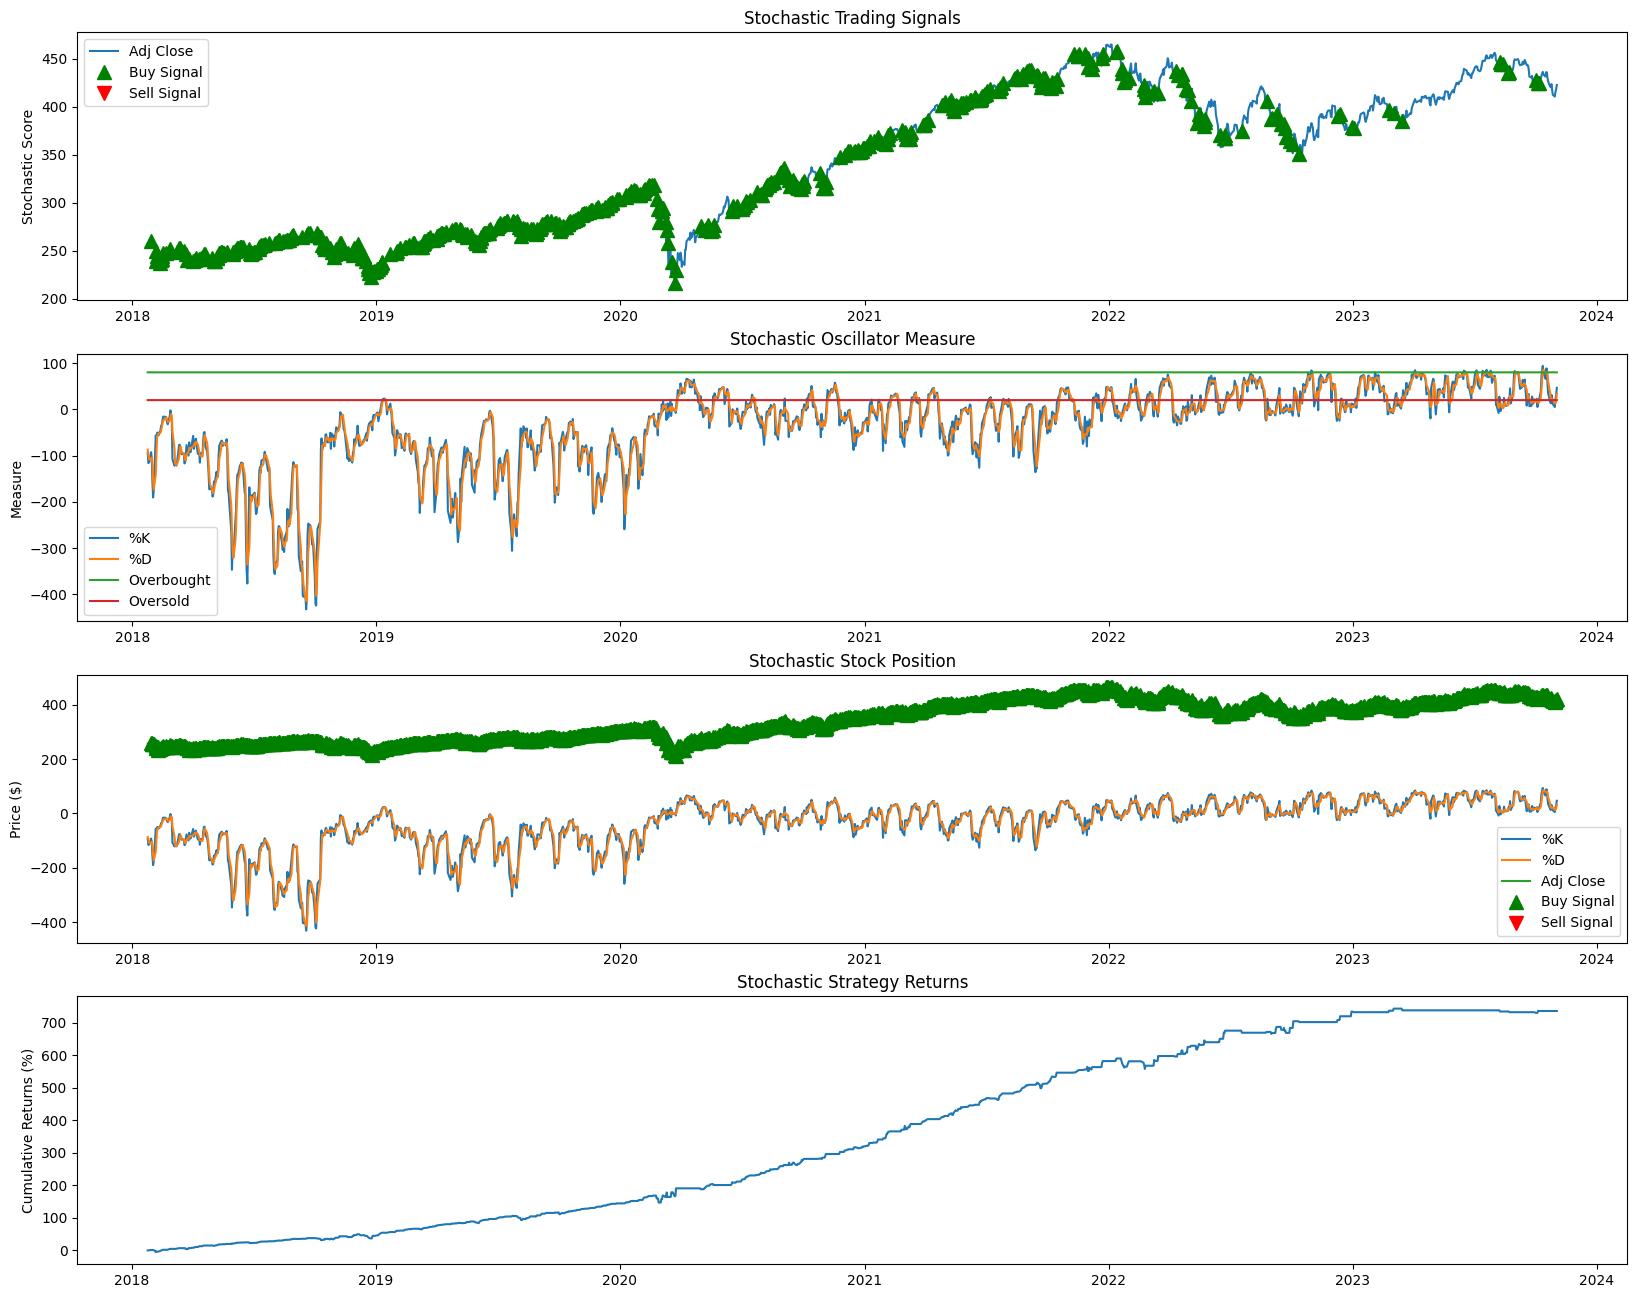

,Open,High,Low,Close,Adj Close,Volume,Lowest_Low,Highest_High,%K,Overbought,Oversold,%D,Buy_Signal,Sell_Signal,Stochastic_Signal,Stochastic_Stock_Position,Stochastic_Daily_Returns,Stochastic_Cumulative_Return,Stochastic_Daily_Return_3_Day_Avg,Stochastic_Daily_Return_3_Day_Std
Date,,,,,,,,,,,,,,,,,,,,
2018-01-30,282.600006,284.739990,281.220001,281.760010,258.504944,131796400,272.920013,286.630005,-105.142805,80,20,-103.995038,0,0,0,1,-0.00000,1.157810,0.003859,0.006685
2018-01-31,282.730011,283.299988,280.679993,281.899994,255.853470,108364800,274.559998,286.630005,-154.983566,80,20,-117.561688,0,0,0,1,-0.00000,1.157810,0.003859,0.006685
2018-02-01,281.070007,283.059998,280.679993,281.579987,255.980545,90102500,276.079987,286.630005,-190.515703,80,20,-150.214024,0,0,0,1,0.00000,1.157810,0.003859,0.006685
2018-02-02,280.079987,280.230011,275.410004,275.450012,255.689972,173174800,275.410004,286.630005,-175.757840,80,20,-173.752369,0,0,0,1,-0.00000,1.157810,0.000000,0.000000
2018-02-05,273.450012,275.850006,263.309998,263.929993,250.123566,294681800,263.309998,286.630005,-56.545574,80,20,-140.939705,1,0,1,1,-0.02177,-1.044410,-0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-27,414.190002,414.600006,409.209991,410.679993,412.549988,107367700,409.209991,438.140015,11.545087,80,20,21.753796,0,0,0,1,-0.00000,736.211089,-0.000000,0.000000
2023-10-30,413.559998,416.679993,412.220001,415.589996,410.679993,86562700,409.209991,438.140015,5.081231,80,20,13.015077,0,0,0,1,-0.00000,736.211089,-0.000000,0.000000
2023-10-31,416.179993,418.529999,414.209991,418.200012,415.589996,79665200,409.209991,438.140015,22.053231,80,20,12.893183,0,0,0,1,0.00000,736.211089,-0.000000,0.000000


In [55]:
generate_signal_stochastic(df,plot=True).dropna()

### 6. Comparing returns of all strategies

In [56]:
# Get a combined dataframe with all the signals
# Generate average and std of daily returns from past 3 days
def get_combined_signal_df(df):
  df_combined = df.copy()
  df_combined = df_combined[['Adj Close']]
  df_combined['Adj Close'] = df_combined['Adj Close'].shift(1)
  df_combined = df_combined.join(generate_signal_BB(df, 20, 2)[['BB_Signal','BB_Daily_Return', 'BB_Stock_Position',
                                                                'BB_Daily_Return_3_Day_Avg','BB_Daily_Return_3_Day_Std']])
  df_combined = df_combined.join(generate_sma_strategy_signal(df)[['SMA_Cross_Signal','SMA_Cross_Daily_Return',
                                                                   'SMA_Stock_Position','SMA_Cross_Daily_Return_3_Day_Avg',
                                                                   'SMA_Cross_Daily_Return_3_Day_Std']])
  df_combined = df_combined.join(generate_ema_strategy_signal(df)[['EMA_Cross_Signal','EMA_Cross_Daily_Return',
                                                                   'EMA_Stock_Position','EMA_Cross_Daily_Return_3_Day_Avg',
                                                                   'EMA_Cross_Daily_Return_3_Day_Std']])
  df_combined = df_combined.join(generate_signal_RSI(df)[['RSI_Signal','RSI_Daily_Return', 'RSI_Stock_Position',
                                                          'RSI_Daily_Return_3_Day_Avg','RSI_Daily_Return_3_Day_Std']])
  df_combined = df_combined.join(generate_signal_stochastic(df)[['Stochastic_Signal','Stochastic_Daily_Returns',
                                                                 'Stochastic_Stock_Position','Stochastic_Daily_Return_3_Day_Avg',
                                                                 'Stochastic_Daily_Return_3_Day_Std']])
  return df_combined

In [57]:
print(X_train.columns)

Index(['Adj Close', 'BB_Signal', 'BB_Daily_Return', 'BB_Stock_Position',
       'BB_Daily_Return_3_Day_Avg', 'BB_Daily_Return_3_Day_Std',
       'SMA_Cross_Signal', 'SMA_Cross_Daily_Return', 'SMA_Stock_Position',
       'SMA_Cross_Daily_Return_3_Day_Avg', 'SMA_Cross_Daily_Return_3_Day_Std',
       'EMA_Cross_Signal', 'EMA_Cross_Daily_Return', 'EMA_Stock_Position',
       'EMA_Cross_Daily_Return_3_Day_Avg', 'EMA_Cross_Daily_Return_3_Day_Std',
       'RSI_Signal', 'RSI_Daily_Return', 'RSI_Stock_Position',
       'RSI_Daily_Return_3_Day_Avg', 'RSI_Daily_Return_3_Day_Std',
       'Stochastic_Signal', 'Stochastic_Daily_Returns',
       'Stochastic_Stock_Position', 'Stochastic_Daily_Return_3_Day_Avg',
       'Stochastic_Daily_Return_3_Day_Std'],
      dtype='object')


In [58]:
get_combined_signal_df(df).head()

,Adj Close,BB_Signal,BB_Daily_Return,BB_Stock_Position,BB_Daily_Return_3_Day_Avg,BB_Daily_Return_3_Day_Std,SMA_Cross_Signal,SMA_Cross_Daily_Return,SMA_Stock_Position,SMA_Cross_Daily_Return_3_Day_Avg,...,RSI_Signal,RSI_Daily_Return,RSI_Stock_Position,RSI_Daily_Return_3_Day_Avg,RSI_Daily_Return_3_Day_Std,Stochastic_Signal,Stochastic_Daily_Returns,Stochastic_Stock_Position,Stochastic_Daily_Return_3_Day_Avg,Stochastic_Daily_Return_3_Day_Std
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,244.057831,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-04,245.601501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-05,246.636642,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-08,248.280228,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


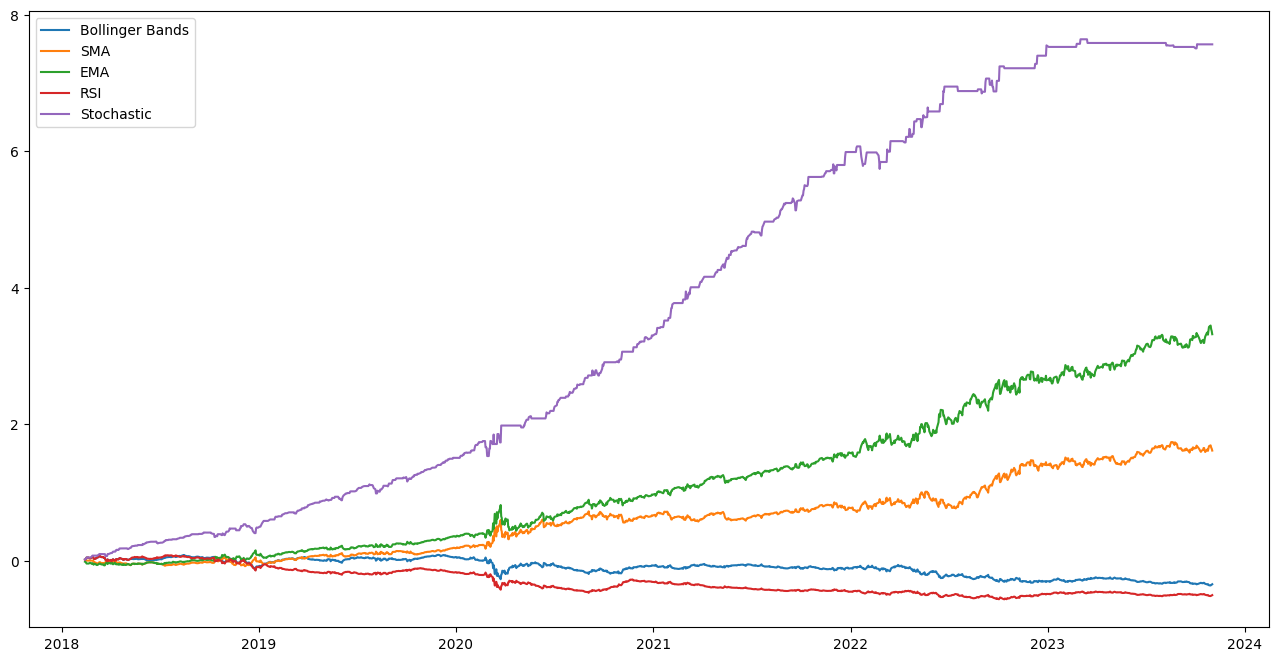

In [59]:
# Plot the cumulative returns for all the strategies
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
plt.plot((get_combined_signal_df(df).dropna()['BB_Daily_Return']+1).cumprod() - 1, label='Bollinger Bands')
plt.plot((get_combined_signal_df(df).dropna()['SMA_Cross_Daily_Return']+1).cumprod() - 1, label='SMA')
plt.plot((get_combined_signal_df(df).dropna()['EMA_Cross_Daily_Return']+1).cumprod() - 1, label='EMA')
plt.plot((get_combined_signal_df(df).dropna()['RSI_Daily_Return']+1).cumprod() - 1, label='RSI')
plt.plot((get_combined_signal_df(df).dropna()['Stochastic_Daily_Returns']+1).cumprod() - 1, label='Stochastic')
plt.legend(loc='upper left')

plt.show()

### 7. Coming up with Ensemble Strategy
1. Framing the problem into a classification problem.
   1. Generate labels for a 'perfect' signal, one that would look like how a human would trade if he knows the exact close price of the next day.
2. Train ensemble of classifiers to predict the 'perfect' signal based on the signals generated by the 5 trading strategies.
3. Exploring some basic feature engineering to improve the performance of the ensemble classifiers.
4. Evaluating the performance of the ensemble classifiers.

In [60]:
# Generating the perfect signal
def generate_perfect_signal(df):
  df_signal = df.copy()
  # Use yesterday's price to make today's decision
  df_signal['Adj Close'] = df_signal['Adj Close'].shift(1)
  # Obtaining the next period's price
  df_signal['tmr_close'] = df_signal['Adj Close'].shift(-1)
  df_signal['perfect_signal'] = df_signal.apply(lambda x: 1 if x['tmr_close'] > x['Adj Close']*1.01
                                                else -1 if x['tmr_close'] < x['Adj Close']*0.99 else 0, axis=1)
  # Define stock position
  stock_position = [0 for i in range(len(df_signal))]

  for i in range(1, len(df_signal)):
    # If there is no position
    if df_signal['perfect_signal'].iloc[i] == 1 and stock_position[i-1] == 0:
      stock_position[i] = 1
    elif df_signal['perfect_signal'].iloc[i] == -1 and stock_position[i-1] == 0:
      stock_position[i] = -1
    # If there is a long position
    elif stock_position[i-1] == 1 and (df_signal['perfect_signal'].iloc[i] == 1 or df_signal['perfect_signal'].iloc[i] == 0):
      stock_position[i] = 1
    elif stock_position[i-1] == 1 and df_signal['perfect_signal'].iloc[i] == -1:
      stock_position[i] = -1
    # If there is a short position
    elif stock_position[i-1] == -1 and (df_signal['perfect_signal'].iloc[i] == -1 or df_signal['perfect_signal'].iloc[i] == 0):
      stock_position[i] = -1
    elif stock_position[i-1] == -1 and df_signal['perfect_signal'].iloc[i] == 1:
      stock_position[i] = 1
    else:
      stock_position[i] = 0

  df_signal['Perfect_Stock_Position'] = stock_position
  df_signal['perfect_daily_return'] = df_signal['Adj Close'].pct_change() * df_signal['Perfect_Stock_Position']
  df_signal['perfect_cumulative_return'] = (df_signal['perfect_daily_return']+1).cumprod()-1
  return df_signal

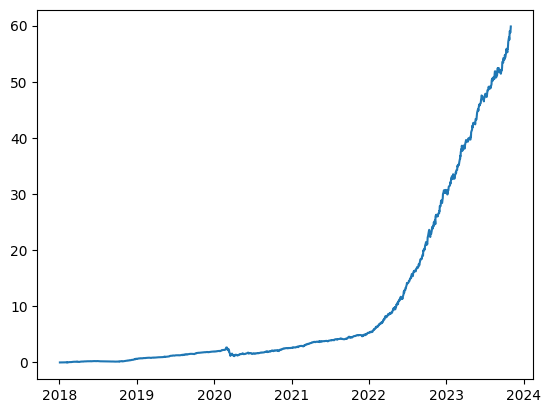

In [61]:
plt.plot(generate_perfect_signal(df).dropna()['perfect_cumulative_return'])

In [62]:
# Add the perfect signal to the combined signal dataframe as a new column 'target'
def get_combined_signal_df_with_target(df):
  df_combined = get_combined_signal_df(df)
  df_combined['target'] = generate_perfect_signal(df)['perfect_signal']
  # Drop na columns
  df_combined = df_combined.dropna()
  return df_combined

In [63]:
ensemble_df = get_combined_signal_df_with_target(df)
ensemble_df.describe()

,Adj Close,BB_Signal,BB_Daily_Return,BB_Stock_Position,BB_Daily_Return_3_Day_Avg,BB_Daily_Return_3_Day_Std,SMA_Cross_Signal,SMA_Cross_Daily_Return,SMA_Stock_Position,SMA_Cross_Daily_Return_3_Day_Avg,...,RSI_Daily_Return,RSI_Stock_Position,RSI_Daily_Return_3_Day_Avg,RSI_Daily_Return_3_Day_Std,Stochastic_Signal,Stochastic_Daily_Returns,Stochastic_Stock_Position,Stochastic_Daily_Return_3_Day_Avg,Stochastic_Daily_Return_3_Day_Std,target
count,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,...,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.0,1441.000000,1441.000000,1441.000000
mean,342.770459,0.008328,-0.000210,0.052047,-0.000232,0.009941,0.000000,0.000750,0.320611,0.000763,...,-0.000405,-0.242193,-0.000423,0.009816,0.360861,0.001516,1.0,0.001525,0.003909,0.029146
std,72.626905,0.290952,0.012962,0.998991,0.006713,0.009304,0.210819,0.012911,0.943500,0.006686,...,0.012958,0.970565,0.006812,0.009319,0.480417,0.007001,0.0,0.003922,0.005947,0.549479
min,211.438690,-1.000000,-0.109424,-1.000000,-0.042623,0.000429,-1.000000,-0.090603,-1.000000,-0.054654,...,-0.109424,-1.000000,-0.042623,0.000219,0.000000,-0.048748,1.0,-0.017248,0.000000,-1.000000
25%,268.934265,0.000000,-0.006373,-1.000000,-0.003616,0.004369,0.000000,-0.005340,-1.000000,-0.002608,...,-0.006373,-1.000000,-0.003896,0.004281,0.000000,0.000000,1.0,0.000000,0.000000,0.000000
50%,353.304230,0.000000,-0.000332,1.000000,-0.000171,0.007662,0.000000,0.000567,1.000000,0.000880,...,-0.000385,-1.000000,-0.000539,0.007420,0.000000,0.000000,1.0,0.000000,0.002037,0.000000
75%,408.298187,0.000000,0.005855,1.000000,0.003208,0.012664,0.000000,0.006612,1.000000,0.004072,...,0.005693,1.000000,0.003065,0.012418,1.000000,0.000591,1.0,0.003266,0.005786,0.000000
max,464.923401,1.000000,0.090603,1.000000,0.054654,0.108780,1.000000,0.109424,1.000000,0.042623,...,0.090603,1.000000,0.054654,0.108780,1.000000,0.090603,1.0,0.030201,0.068241,1.000000


In [64]:
# Split into train and test datasets, Reserve last 12 months of data for testing
end_date_index = ensemble_df.index.max() - pd.DateOffset(months=12)
train_df = ensemble_df[:end_date_index]
test_df = ensemble_df[end_date_index:]

# Split into X_train, y_train, X_test, y_test
X_train = train_df.drop(columns=['target'])
y_train = train_df['target']
X_test = test_df.drop(columns=['target'])
y_test = test_df['target']


# Print distribution of target variable
print("Distribution of target variable in training set:\n", y_train.value_counts())
print("Distribution of target variable in test set:\n", y_test.value_counts())


# Print the shape
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Distribution of target variable in training set:
  0    828
 1    201
-1    161
Name: target, dtype: int64
Distribution of target variable in test set:
  0    177
 1     38
-1     37
Name: target, dtype: int64
Shape of X_train: (1190, 26)
Shape of y_train: (1190,)
Shape of X_test: (252, 26)
Shape of y_test: (252,)


In [65]:
pip install bayesian-optimization

#### Model 1: Random Forest Classifier

In [66]:
# Optimise Random Forest Classifier with bayesian optimisation
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
# Create cross validation folds
tscv = TimeSeriesSplit(n_splits=5)

# Define Objective Function
from bayes_opt import BayesianOptimization

def objective(n_estimators, max_depth):
    model = OneVsRestClassifier(RandomForestClassifier(n_estimators=int(n_estimators),
                                 max_depth = int(max_depth),
                                 random_state =42))
    return cross_val_score(model,X_train, y_train, cv=tscv, scoring="balanced_accuracy").mean()

# Bounds for hyperparameters
param_bounds = {
    'n_estimators': (50, 400),
    'max_depth': (1, 50),
}

# Maximise objective function
optimizer = BayesianOptimization(f=objective, pbounds=param_bounds, random_state=42)
optimizer.maximize(init_points=5, n_iter=15)


|   iter    |  target   | max_depth | n_esti... |
-------------------------------------------------
| 1         | 0.3662    | 19.35     | 382.8     |
| 2         | 0.3621    | 36.87     | 259.5     |
| 3         | 0.3721    | 8.645     | 104.6     |
| 4         | 0.3495    | 3.846     | 353.2     |
| 5         | 0.3647    | 30.45     | 297.8     |
| 6         | 0.3643    | 9.907     | 104.9     |
| 7         | 0.3631    | 7.929     | 105.2     |
| 8         | 0.3643    | 9.187     | 104.5     |
| 9         | 0.3333    | 1.277     | 212.3     |
| 10        | 0.3712    | 8.245     | 103.7     |
| 11        | 0.366     | 20.96     | 382.0     |
| 12        | 0.3638    | 6.636     | 102.9     |
| 13        | 0.3721    | 8.896     | 102.4     |
| 14        | 0.3635    | 10.2      | 102.5     |
| 15        | 0.3721    | 8.814     | 101.2     |
| 16        | 0.3677    | 9.721     | 99.68     |
| 17        | 0.3731    | 8.341     | 99.59     |
| 18        | 0.3571    | 5.936     | 100.2     |


In [67]:
# Find the best parameters
best_params = optimizer.max['params']
best_params

{'max_depth': 8.341448425497452, 'n_estimators': 99.59427528300273}

In [68]:
# Train a Random Forest Classifier with Kfold walk-forward validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier

# Do a 5-fold walk-forward validation
tscv = TimeSeriesSplit(n_splits=5, max_train_size=400)
# Store accuracy scores
acc_scores = []
iter = 0
for train_index, val_index in tscv.split(X_train):
  iter +=1
  # Split train and test sets
  X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
  y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
  print(f"iteration {iter}:\ntrain_size: {len(train_index)}\nval_size: {len(val_index)}\n")

  # Train a Random Forest Classifier
  rf_model = OneVsRestClassifier(RandomForestClassifier(n_estimators=int(best_params['n_estimators']),
                                                        max_depth=int(best_params['max_depth']),random_state=42))
  rf_model.fit(X_train_fold, y_train_fold)

  # Make predictions on the test set
  y_pred_fold = rf_model.predict(X_val_fold)

  # Calculate accuracy score
  acc_score = accuracy_score(y_val_fold, y_pred_fold)
  acc_scores.append(acc_score)
  print("Accuracy score:", acc_score)

# Print average accuracy score
print("Average accuracy score:", np.mean(acc_scores))

# Train a Random Forest Classifier on the entire training set
rf_model = OneVsRestClassifier(RandomForestClassifier(n_estimators=int(best_params['n_estimators']),
                                                      max_depth=int(best_params['max_depth']),random_state=42))
rf_model.fit(X_train.iloc[-400:], y_train.iloc[-400:])

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Calculate accuracy score on test set
acc_score = accuracy_score(y_test, y_pred)
print("Accuracy score:", acc_score)

# Based on y_pred, calculate the daily returns
test_df['RF_Signal'] = y_pred
test_df['RF_Signal'] = test_df['RF_Signal']

# Define stock position
stock_position = [0 for i in range(len(test_df))]

for i in range(1, len(test_df)):
  # If there is no position
  if test_df['RF_Signal'].iloc[i] == 1 and stock_position[i-1] == 0:
    stock_position[i] = 1
  elif test_df['RF_Signal'].iloc[i] == -1 and stock_position[i-1] == 0:
     stock_position[i] = -1
  # If there is a long position
  elif stock_position[i-1] == 1 and (test_df['RF_Signal'].iloc[i] == 1 or test_df['RF_Signal'].iloc[i] == 0):
    stock_position[i] = 1
  elif stock_position[i-1] == 1 and test_df['RF_Signal'].iloc[i] == -1:
    stock_position[i] = -1
  # If there is a short position
  elif stock_position[i-1] == -1 and (test_df['RF_Signal'].iloc[i] == -1 or test_df['RF_Signal'].iloc[i] == 0):
   stock_position[i] = -1
  elif stock_position[i-1] == -1 and test_df['RF_Signal'].iloc[i] == 1:
    stock_position[i] = 1
  else:
    stock_position[i] = 0

test_df['RF_Stock_Position'] = stock_position

test_df['RF_Daily_Return'] = test_df['Adj Close'].pct_change() * test_df['RF_Stock_Position']

iteration 1:
train_size: 200
val_size: 198

Accuracy score: 0.7474747474747475
iteration 2:
train_size: 398
val_size: 198

Accuracy score: 0.6818181818181818
iteration 3:
train_size: 400
val_size: 198

Accuracy score: 0.6767676767676768
iteration 4:
train_size: 400
val_size: 198

Accuracy score: 0.8131313131313131
iteration 5:
train_size: 400
val_size: 198

Accuracy score: 0.42424242424242425
Average accuracy score: 0.6686868686868687
Accuracy score: 0.6746031746031746


<ipython-input-68-7ad4b7424c86>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['RF_Signal'] = y_pred
<ipython-input-68-7ad4b7424c86>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['RF_Signal'] = test_df['RF_Signal']
<ipython-input-68-7ad4b7424c86>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

In [69]:
#pip install shap

In [70]:
# # Explaining Tree model with SHAP value
# import shap
# # Fits the explainer
# explainer = shap.Explainer(rf_model.predict, X_test)
# # Calculates the SHAP values - It takes some time
# shap_values = explainer(X_test)
# shap.summary_plot(shap_values)


In [71]:
# shap.plots.bar(shap_values)

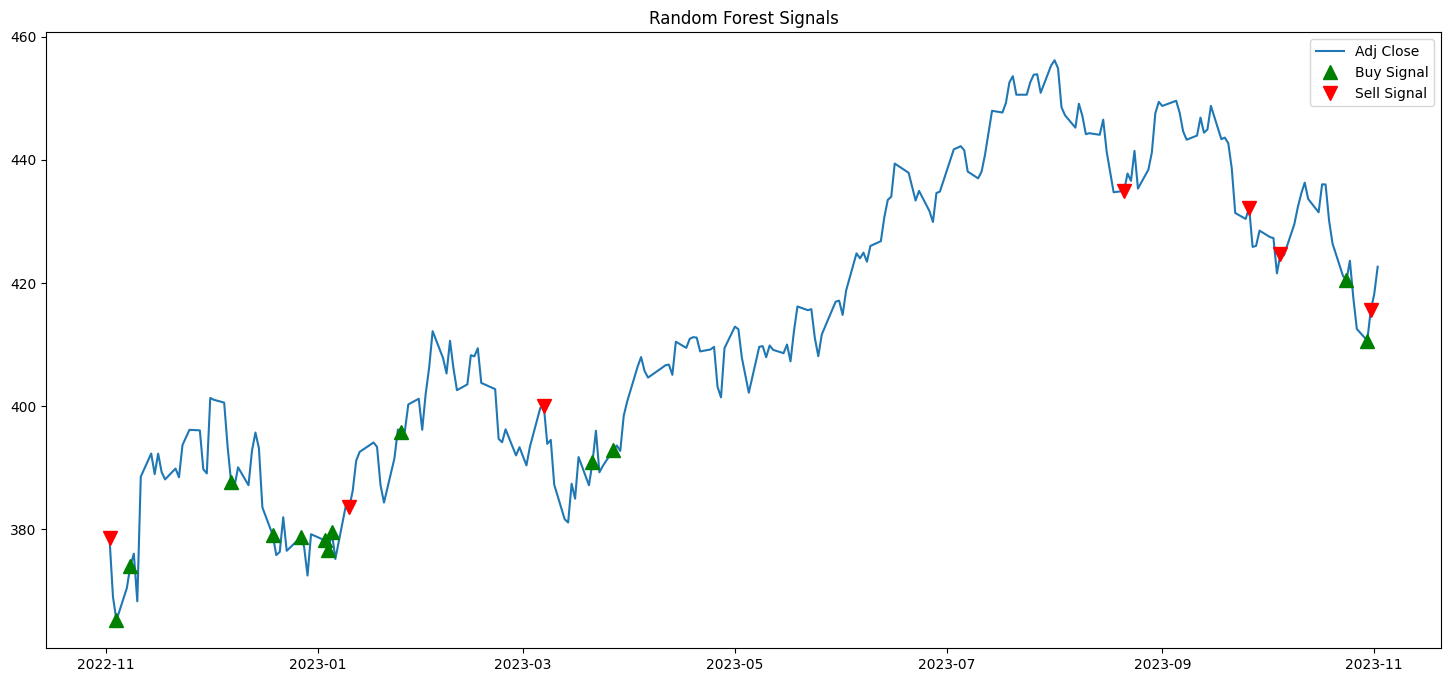

In [72]:
# Plot the signals
plt.figure(figsize = (18,8))
plt.plot(test_df['Adj Close'], label = 'Adj Close')
plt.plot(test_df[test_df['RF_Signal']== 1].index,
         test_df['Adj Close'][test_df['RF_Signal']==1],
         '^', markersize = 10, color = 'g', label = "Buy Signal")
plt.plot(test_df[test_df['RF_Signal']== -1].index,
         test_df['Adj Close'][test_df['RF_Signal']==-1],
         'v', markersize = 10, color = 'r', label = "Sell Signal")
plt.title("Random Forest Signals")
plt.legend()

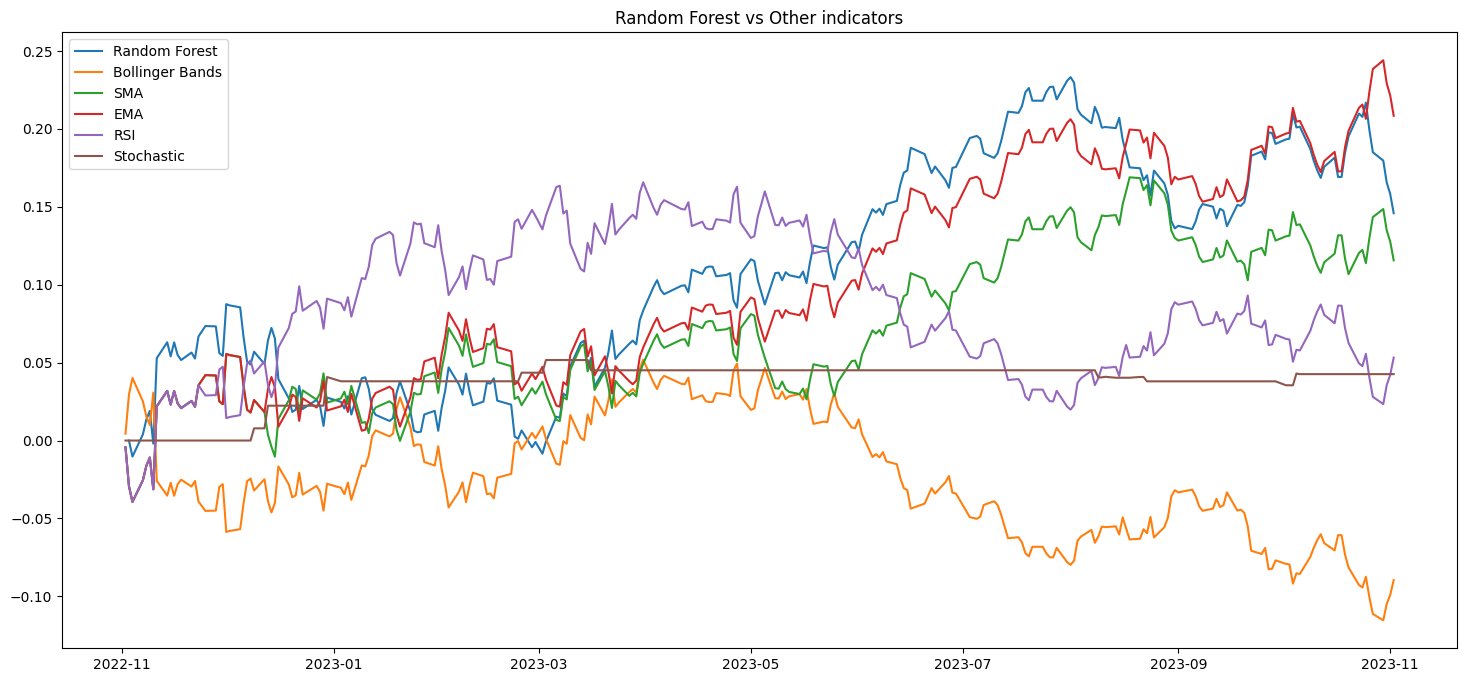

In [73]:
# Compare with the other strategies

plt.figure(figsize=(18,8))
plt.plot((test_df['RF_Daily_Return']+1).cumprod()-1, label='Random Forest')
plt.plot((test_df['BB_Daily_Return']+1).cumprod()-1, label='Bollinger Bands')
plt.plot((test_df['SMA_Cross_Daily_Return']+1).cumprod()-1, label='SMA')
plt.plot((test_df['EMA_Cross_Daily_Return']+1).cumprod()-1, label='EMA')
plt.plot((test_df['RSI_Daily_Return']+1).cumprod()-1, label='RSI')
plt.plot((test_df['Stochastic_Daily_Returns']+1).cumprod()-1, label='Stochastic')
plt.title("Random Forest vs Other indicators")
plt.legend(loc='upper left')

plt.show()

#### Model 2: Gradient Boosting

In [74]:
# Train a Gradient Boosting Classifier with Kfold walk-forward validation
from sklearn.ensemble import GradientBoostingClassifier
# Do a 5-fold walk-forward validation
tscv = TimeSeriesSplit(n_splits=5, max_train_size=400)
# Store accuracy scores
acc_scores = []
iter = 0
for train_index, val_index in tscv.split(X_train):
  iter +=1
  # Split train and test sets
  X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
  y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
  print(f"iteration {iter}:\ntrain_size: {len(train_index)}\nval_size: {len(val_index)}\n")

  # Train a Gradient Boosting Classifier
  gb_model = OneVsRestClassifier(GradientBoostingClassifier(n_estimators=int(best_params['n_estimators']),
                                   max_depth=int(best_params['max_depth']),
                                   random_state=42))
  gb_model.fit(X_train_fold, y_train_fold)

  # Make predictions on the test set
  y_pred_fold = gb_model.predict(X_val_fold)

  # Calculate accuracy score
  acc_score = accuracy_score(y_val_fold, y_pred_fold)
  acc_scores.append(acc_score)
  print("Accuracy score:", acc_score)

# Print average accuracy score
print("Average accuracy score:", np.mean(acc_scores))

# Train a Gradient Boosting Classifier on the entire training set
gb_model = OneVsRestClassifier(GradientBoostingClassifier(n_estimators=100, random_state =42))
gb_model.fit(X_train.iloc[-400:], y_train.iloc[-400:])

# Make predictions on the test set
y_pred = gb_model.predict(X_test)

# Calculate accuracy score on test set
acc_score = accuracy_score(y_test, y_pred)
print("Accuracy score:", acc_score)

# Based on y_pred, calculate the daily returns
test_df['GB_Signal'] = y_pred
test_df['GB_Signal'] = test_df['GB_Signal']


# Define stock position
stock_position = [0 for i in range(len(test_df))]

for i in range(1, len(test_df)):
  # If there is no position
  if test_df['GB_Signal'].iloc[i] == 1 and stock_position[i-1] == 0:
    stock_position[i] = 1
  elif test_df['GB_Signal'].iloc[i] == -1 and stock_position[i-1] == 0:
     stock_position[i] = -1
  # If there is a long position
  elif stock_position[i-1] == 1 and (test_df['GB_Signal'].iloc[i] == 1 or test_df['GB_Signal'].iloc[i] == 0):
    stock_position[i] = 1
  elif stock_position[i-1] == 1 and test_df['GB_Signal'].iloc[i] == -1:
    stock_position[i] = -1
  # If there is a short position
  elif stock_position[i-1] == -1 and (test_df['GB_Signal'].iloc[i] == -1 or test_df['GB_Signal'].iloc[i] == 0):
   stock_position[i] = -1
  elif stock_position[i-1] == -1 and test_df['GB_Signal'].iloc[i] == 1:
    stock_position[i] = 1
  else:
    stock_position[i] = 0

test_df['GB_Stock_Position'] = stock_position
test_df['GB_Daily_Return'] = test_df['Adj Close'].pct_change() * test_df['GB_Stock_Position'].shift(1)

iteration 1:
train_size: 200
val_size: 198

Accuracy score: 0.7424242424242424
iteration 2:
train_size: 398
val_size: 198

Accuracy score: 0.6363636363636364
iteration 3:
train_size: 400
val_size: 198

Accuracy score: 0.5959595959595959
iteration 4:
train_size: 400
val_size: 198

Accuracy score: 0.7626262626262627
iteration 5:
train_size: 400
val_size: 198

Accuracy score: 0.3686868686868687
Average accuracy score: 0.6212121212121212
Accuracy score: 0.6349206349206349


<ipython-input-74-2e05d855206b>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['GB_Signal'] = y_pred
<ipython-input-74-2e05d855206b>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['GB_Signal'] = test_df['GB_Signal']
<ipython-input-74-2e05d855206b>:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

In [75]:
# # Explaining Tree model with SHAP value
# import shap
# # Fits the explainer
# explainer = shap.Explainer(gb_model.predict, X_test)
# # Calculates the SHAP values - It takes some time
# shap_values = explainer(X_test)
# shap.summary_plot(shap_values)


In [76]:
# shap.plots.bar(shap_values)

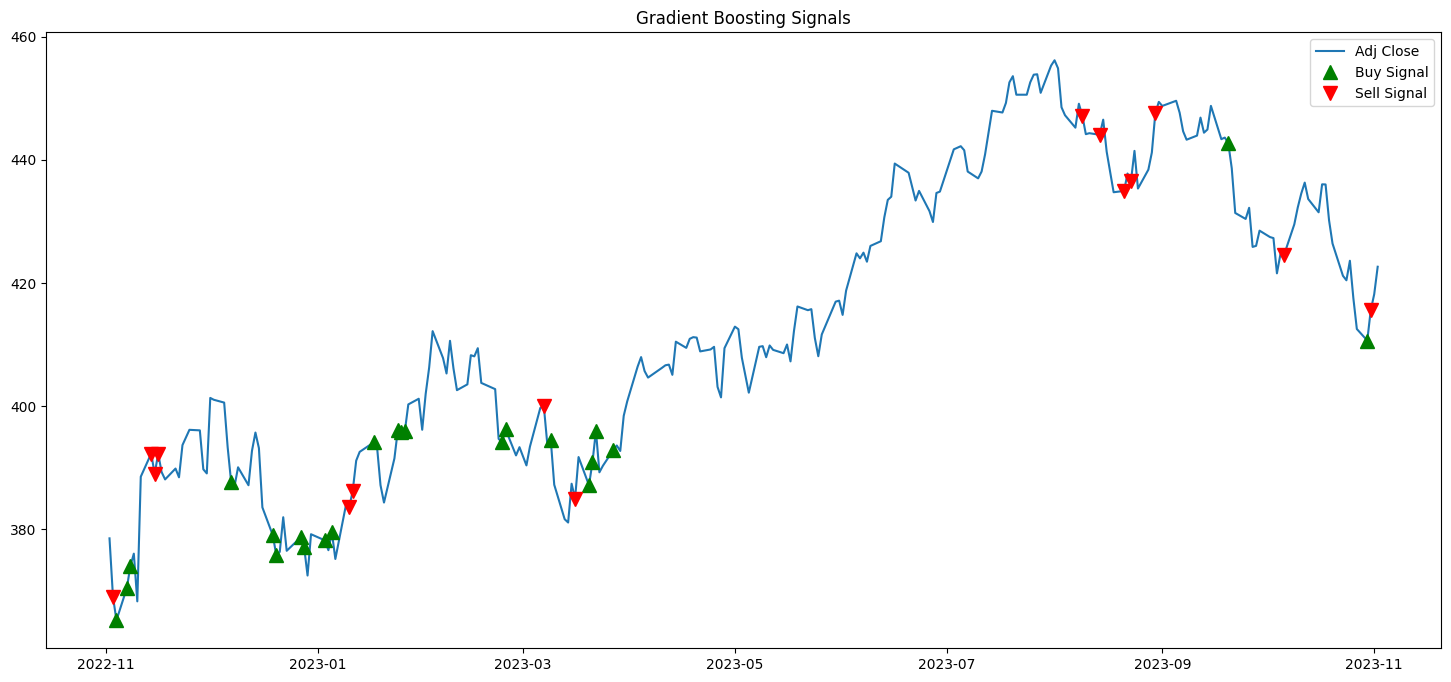

In [77]:
# Plot the signals
plt.figure(figsize = (18,8))
plt.plot(test_df['Adj Close'], label = 'Adj Close')
plt.plot(test_df[test_df['GB_Signal']== 1].index,
         test_df['Adj Close'][test_df['GB_Signal']==1],
         '^', markersize = 10, color = 'g', label = "Buy Signal")
plt.plot(test_df[test_df['GB_Signal']== -1].index,
         test_df['Adj Close'][test_df['GB_Signal']==-1],
         'v', markersize = 10, color = 'r', label = "Sell Signal")
plt.title("Gradient Boosting Signals")
plt.legend()

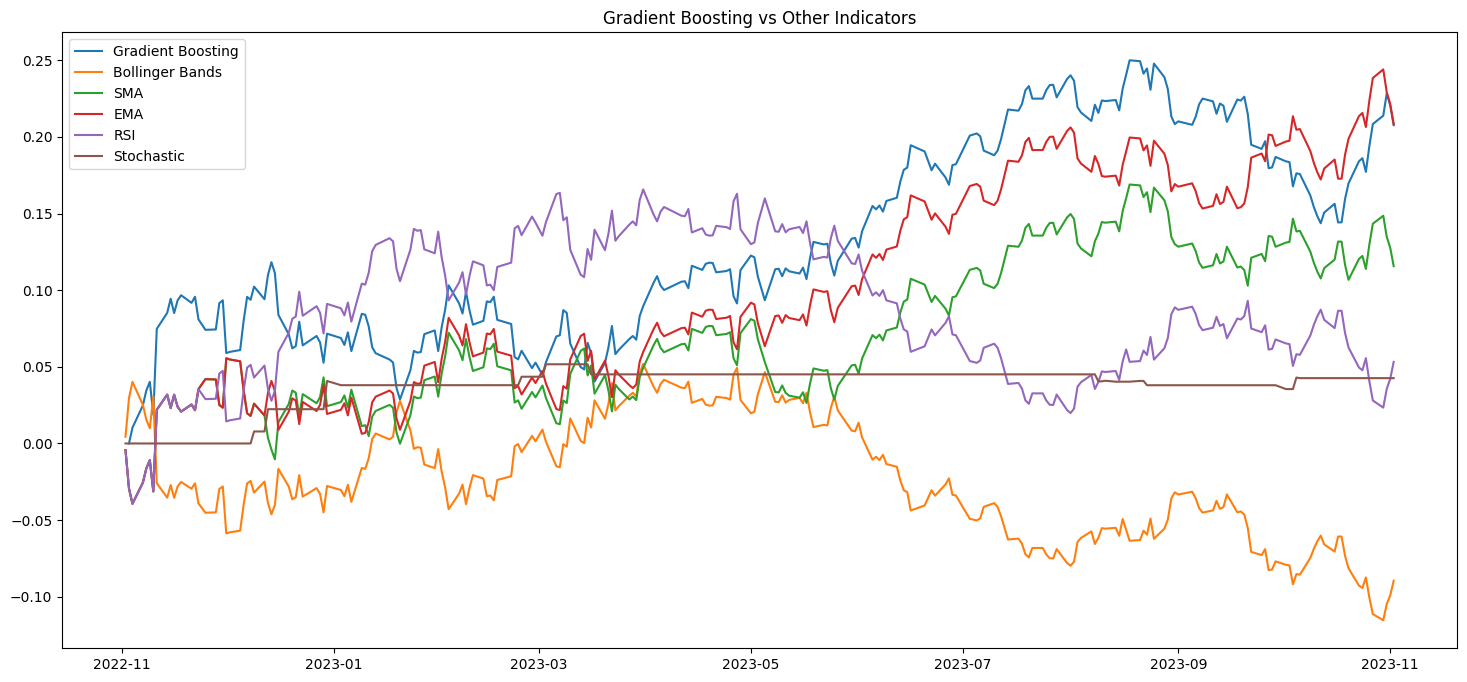

In [78]:
# Compare with the other strategies

plt.figure(figsize=(18,8))
plt.plot((test_df['GB_Daily_Return']+1).cumprod()-1, label='Gradient Boosting')
plt.plot((test_df['BB_Daily_Return']+1).cumprod()-1, label='Bollinger Bands')
plt.plot((test_df['SMA_Cross_Daily_Return']+1).cumprod()-1, label='SMA')
plt.plot((test_df['EMA_Cross_Daily_Return']+1).cumprod()-1, label='EMA')
plt.plot((test_df['RSI_Daily_Return']+1).cumprod()-1, label='RSI')
plt.plot((test_df['Stochastic_Daily_Returns']+1).cumprod()-1, label='Stochastic')
plt.legend(loc='upper left')
plt.title("Gradient Boosting vs Other Indicators")

plt.show()

#### Model 3: Stacking

In [79]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score

import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.multiclass import OneVsRestClassifier

# Create a list of base models
estimators = []
estimators.append(('AdaBoostClassifier', AdaBoostClassifier(random_state=42)) )
estimators.append(('Bagging Classifier', BaggingClassifier(random_state=42)) )
estimators.append(('Bernoulli NB', BernoulliNB() ))
estimators.append(('Decision Tree Classifier', DecisionTreeClassifier(random_state=42) ))
estimators.append(('Extra Tree Classifier', ExtraTreesClassifier(random_state=42) ))
estimators.append(('Gaussian NB', GaussianNB() ))
estimators.append(('Gradient Boosting Classifier', OneVsRestClassifier(GradientBoostingClassifier(n_estimators=100,random_state=42) )))
estimators.append(('RF Classifier', OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42))))
estimators.append(('XGB', XGBClassifier(random_state=42) ))
meta_learner_model = LogisticRegression(random_state=42,max_iter=1000,multi_class='ovr')

model = OneVsRestClassifier(StackingClassifier(estimators=estimators, final_estimator=meta_learner_model))

tscv = TimeSeriesSplit(n_splits=5, max_train_size=400)
# Store accuracy scores
acc_scores = []
iter = 0
for train_index, val_index in tscv.split(X_train):
  iter +=1
  # Split train and test sets
  X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
  y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
  print(f"iteration {iter}:\ntrain_size: {len(train_index)}\nval_size: {len(val_index)}\n")


  # Train a Gradient Boosting Classifier
  model.fit(X_train_fold, y_train_fold)

  # Make predictions on the test set
  y_pred_fold = model.predict(X_val_fold)

  # Calculate accuracy score
  acc_score = accuracy_score(y_val_fold, y_pred_fold)
  acc_scores.append(acc_score)
  print("Accuracy score:", acc_score)

# Print average accuracy score
print("Average accuracy score:", np.mean(acc_scores))

# # Train a Gradient Boosting Classifier on the entire training set
model.fit(X_train.iloc[-400:], y_train.iloc[-400:])

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate accuracy score on test set
acc_score = accuracy_score(y_test, y_pred)
print("Accuracy score:", acc_score)

# Based on y_pred, calculate the daily returns
test_df['Stacking_Signal'] = y_pred

# Define stock position
stock_position = [0 for i in range(len(test_df))]

for i in range(1, len(test_df)):
  # If there is no position
  if test_df['Stacking_Signal'].iloc[i] == 1 and stock_position[i-1] == 0:
    stock_position[i] = 1
  elif test_df['Stacking_Signal'].iloc[i] == -1 and stock_position[i-1] == 0:
     stock_position[i] = -1
  # If there is a long position
  elif stock_position[i-1] == 1 and (test_df['Stacking_Signal'].iloc[i] == 1 or test_df['Stacking_Signal'].iloc[i] == 0):
    stock_position[i] = 1
  elif stock_position[i-1] == 1 and test_df['Stacking_Signal'].iloc[i] == -1:
    stock_position[i] = -1
  # If there is a short position
  elif stock_position[i-1] == -1 and (test_df['Stacking_Signal'].iloc[i] == -1 or test_df['Stacking_Signal'].iloc[i] == 0):
   stock_position[i] = -1
  elif stock_position[i-1] == -1 and test_df['Stacking_Signal'].iloc[i] == 1:
    stock_position[i] = 1
  else:
    stock_position[i] = 0

test_df['Stacking_Stock_Position'] = stock_position

test_df['Stacking_Daily_Return'] = test_df['Adj Close'].pct_change() * test_df['Stacking_Stock_Position']

iteration 1:
train_size: 200
val_size: 198

Accuracy score: 0.7575757575757576
iteration 2:
train_size: 398
val_size: 198

Accuracy score: 0.6515151515151515
iteration 3:
train_size: 400
val_size: 198

Accuracy score: 0.6767676767676768
iteration 4:
train_size: 400
val_size: 198

Accuracy score: 0.803030303030303
iteration 5:
train_size: 400
val_size: 198

Accuracy score: 0.5
Average accuracy score: 0.6777777777777778
Accuracy score: 0.6904761904761905


<ipython-input-79-72cf2c188af8>:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Stacking_Signal'] = y_pred
<ipython-input-79-72cf2c188af8>:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Stacking_Stock_Position'] = stock_position
<ipython-input-79-72cf2c188af8>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

In [80]:
# # Explaining Tree model with SHAP value
# import shap
# # Fits the explainer
# explainer = shap.Explainer(model.predict, X_test)
# # Calculates the SHAP values - It takes some time
# shap_values = explainer(X_test)
# shap.summary_plot(shap_values)


In [81]:
# shap.plots.bar(shap_values)

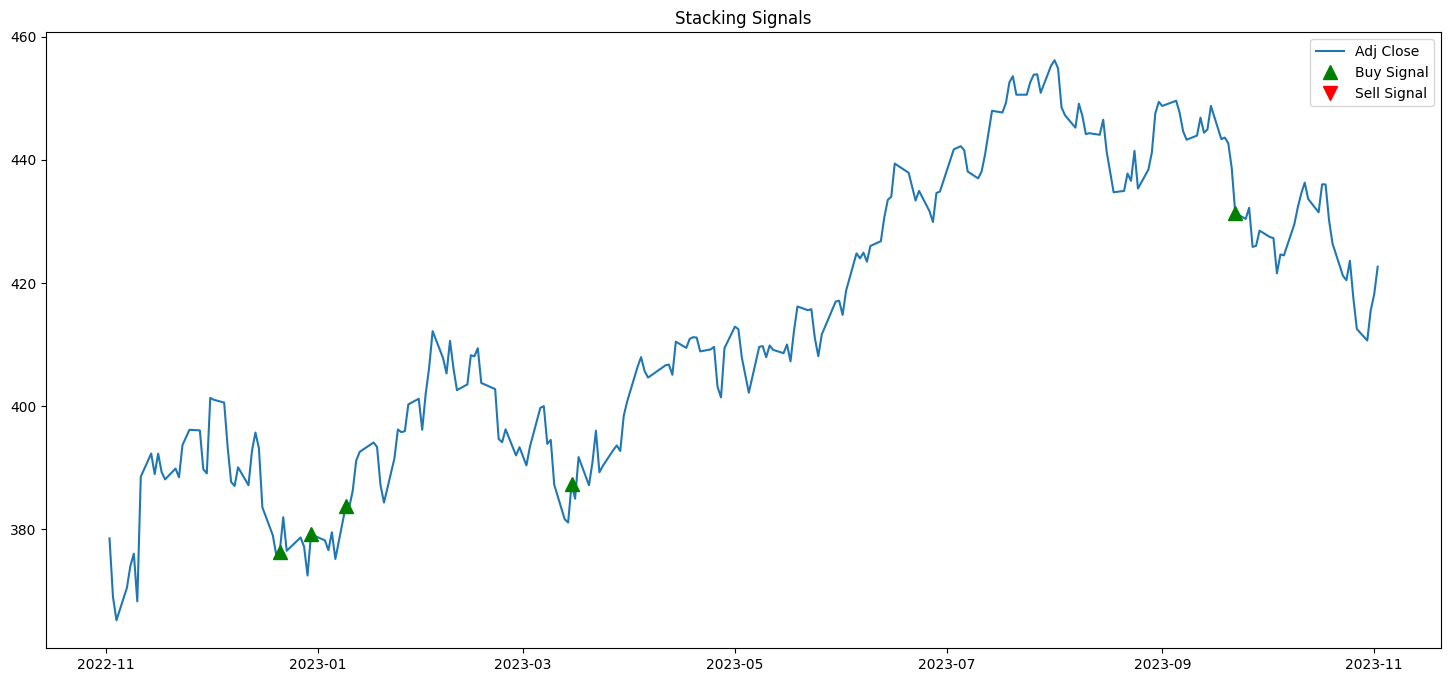

In [82]:
# Plot the signals
plt.figure(figsize = (18,8))
plt.plot(test_df['Adj Close'], label = 'Adj Close')
plt.plot(test_df[test_df['Stacking_Signal']== 1].index,
         test_df['Adj Close'][test_df['Stacking_Signal']==1],
         '^', markersize = 10, color = 'g', label = "Buy Signal")
plt.plot(test_df[test_df['Stacking_Signal']== -1].index,
         test_df['Adj Close'][test_df['Stacking_Signal']==-1],
         'v', markersize = 10, color = 'r', label = "Sell Signal")
plt.title("Stacking Signals")
plt.legend()

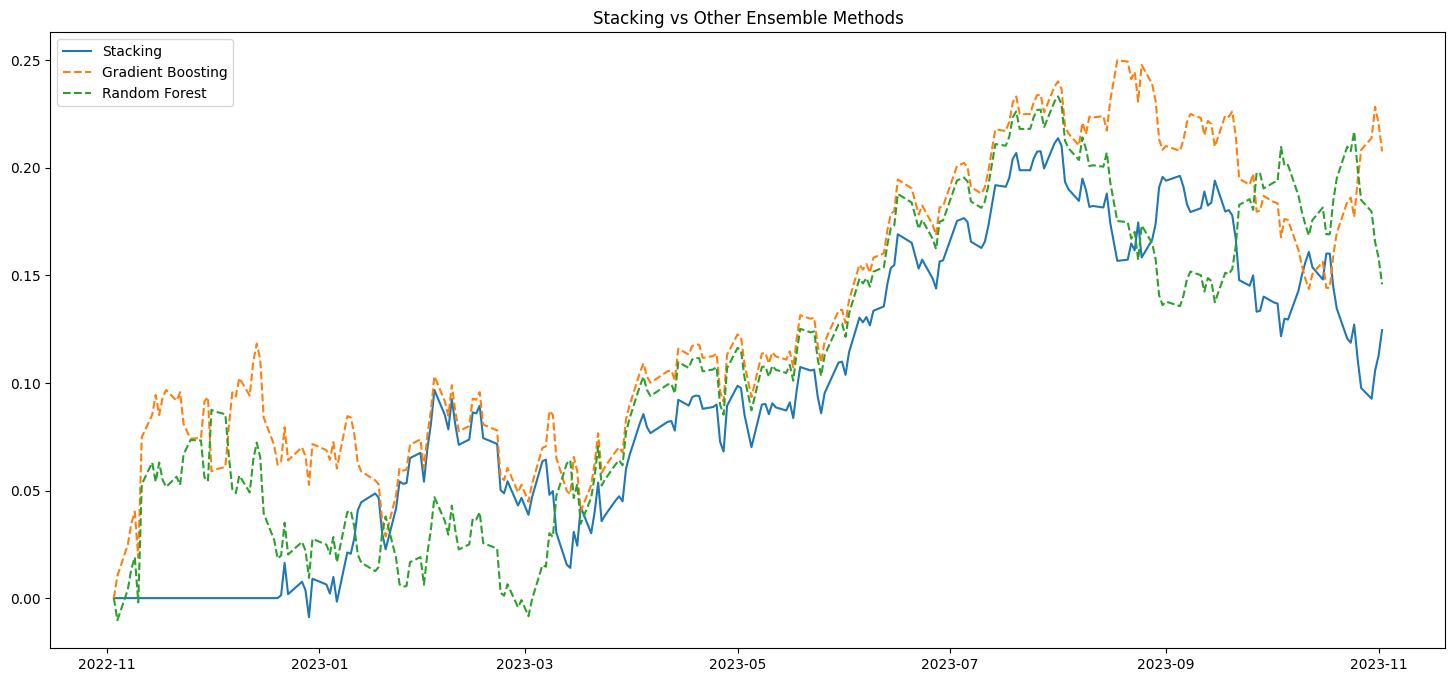

In [83]:
plt.figure(figsize=(18,8))
plt.plot((test_df['Stacking_Daily_Return']+1).cumprod()-1, label='Stacking')
plt.plot((test_df['GB_Daily_Return']+1).cumprod()-1, label='Gradient Boosting',linestyle='dashed')
plt.plot((test_df['RF_Daily_Return']+1).cumprod()-1, label='Random Forest',linestyle='dashed')
plt.legend(loc='upper left')
plt.title("Stacking vs Other Ensemble Methods")
plt.show()

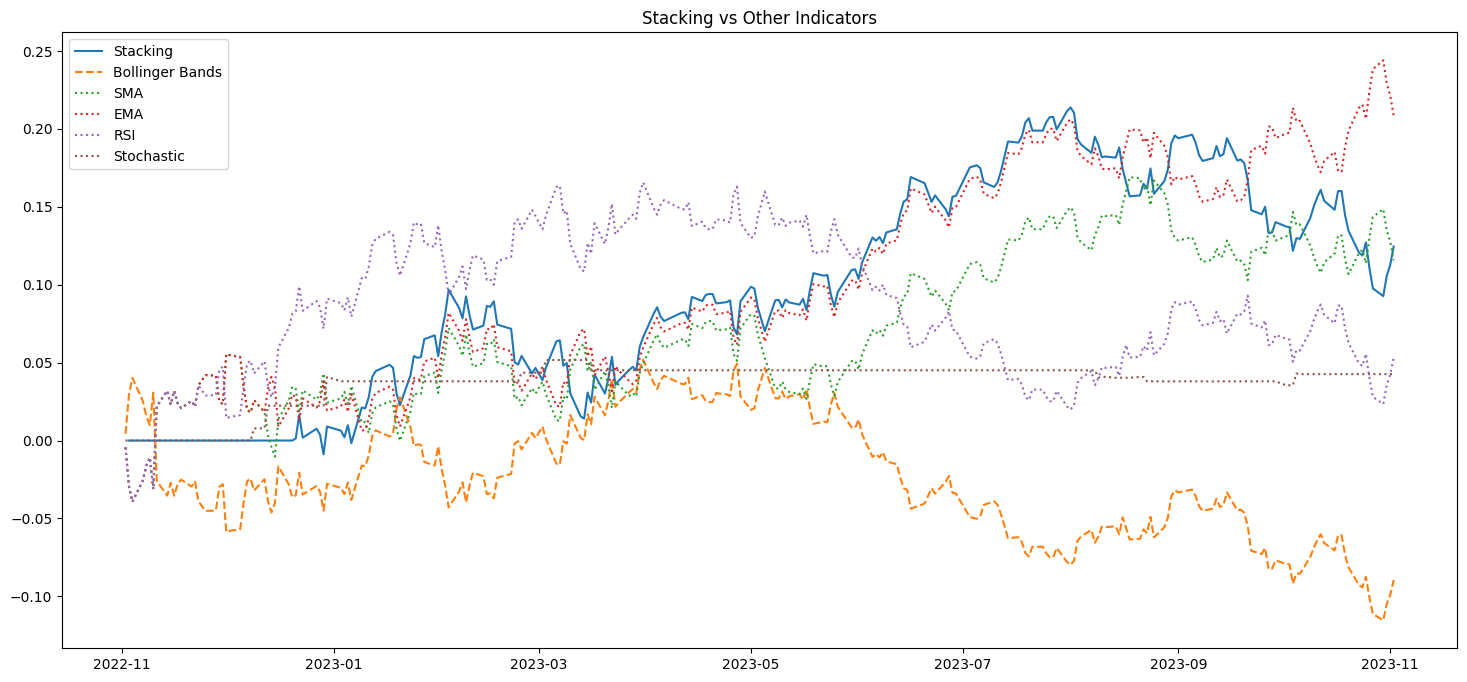

In [84]:
# Compare with the other strategies

plt.figure(figsize=(18,8))
plt.plot((test_df['Stacking_Daily_Return']+1).cumprod()-1, label='Stacking')
plt.plot((test_df['BB_Daily_Return']+1).cumprod()-1, label='Bollinger Bands', linestyle='--')
plt.plot((test_df['SMA_Cross_Daily_Return']+1).cumprod()-1, label='SMA', linestyle='dotted')
plt.plot((test_df['EMA_Cross_Daily_Return']+1).cumprod()-1, label='EMA', linestyle='dotted')
plt.plot((test_df['RSI_Daily_Return']+1).cumprod()-1, label='RSI', linestyle='dotted')
plt.plot((test_df['Stochastic_Daily_Returns']+1).cumprod()-1, label='Stochastic', linestyle='dotted')
plt.legend(loc='upper left')
plt.title("Stacking vs Other Indicators")
plt.show()